# Deep Learning : Image Classification and Regression
Hamzaoui Dimitri

In [1]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
from keras.models import Model, Input
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

Using TensorFlow backend.


In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)
  
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

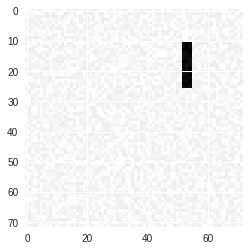

In [4]:
im = generate_a_rectangle(20, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

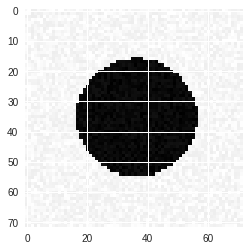

In [5]:
im = generate_a_disk(20)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

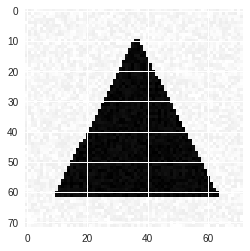

In [6]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [0]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
  
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]
  

In [0]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape((3,2))
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## I)  Simple Classification

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Add
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

In [10]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
print(X_train.shape)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(300, 5184)


In [11]:
Y_train = to_categorical(Y_train,)
Y_train[12]

array([0., 1., 0.], dtype=float32)

### SGD Optimizer

In [12]:
optimizer_SGD = SGD(lr = 1e-4)

model_SGD = Sequential()

model_SGD.add(Dense(3, activation = "softmax", input_shape = (X_train.shape[1],)))

model_SGD.compile(optimizer = optimizer_SGD, loss='mean_squared_error', metrics = ['accuracy'])
model_SGD.fit(X_train, Y_train, batch_size=8, epochs = 200)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_SGD.predict(X_test)

Epoch 1/200
300/300 [==============================] - 1s 3ms/step - loss: 0.2557 - acc: 0.4000
Epoch 2/200
300/300 [==============================] - 0s 442us/step - loss: 0.2529 - acc: 0.4333
Epoch 3/200
300/300 [==============================] - 0s 458us/step - loss: 0.2510 - acc: 0.4267
Epoch 4/200
300/300 [==============================] - 0s 436us/step - loss: 0.2488 - acc: 0.4300
Epoch 5/200
300/300 [==============================] - 0s 443us/step - loss: 0.2464 - acc: 0.4233
Epoch 6/200
300/300 [==============================] - 0s 435us/step - loss: 0.2435 - acc: 0.4167
Epoch 7/200
300/300 [==============================] - 0s 438us/step - loss: 0.2395 - acc: 0.4200
Epoch 8/200
300/300 [==============================] - 0s 478us/step - loss: 0.2354 - acc: 0.4000
Epoch 9/200
300/300 [==============================] - 0s 437us/step - loss: 0.2320 - acc: 0.4067
Epoch 10/200
300/300 [==============================] - 0s 434us/step - loss: 0.2285 - acc: 0.4100
Epoch 11/200
300/300 

array([[1.0000000e+00, 2.6179202e-21, 0.0000000e+00]], dtype=float32)

### ADAM Optimizer

In [13]:
model_adam = Sequential()

model_adam.add(Dense(3, activation = "softmax", input_shape = (X_train.shape[1],)))

optimizer_adam = Adam(lr=3e-4)
model_adam.compile(optimizer = optimizer_adam, loss='categorical_crossentropy', metrics = ['accuracy'])
model_adam.fit(X_train, Y_train, batch_size=32, epochs = 50)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

Epoch 1/50
300/300 [==============================] - 0s 595us/step - loss: 1.2127 - acc: 0.4367
Epoch 2/50
300/300 [==============================] - 0s 174us/step - loss: 0.8786 - acc: 0.5767
Epoch 3/50
300/300 [==============================] - 0s 160us/step - loss: 0.7522 - acc: 0.6500
Epoch 4/50
300/300 [==============================] - 0s 167us/step - loss: 0.6408 - acc: 0.7167
Epoch 5/50
300/300 [==============================] - 0s 180us/step - loss: 0.5614 - acc: 0.7467
Epoch 6/50
300/300 [==============================] - 0s 169us/step - loss: 0.5208 - acc: 0.7533
Epoch 7/50
300/300 [==============================] - 0s 168us/step - loss: 0.4911 - acc: 0.7667
Epoch 8/50
300/300 [==============================] - 0s 174us/step - loss: 0.4269 - acc: 0.8600
Epoch 9/50
300/300 [==============================] - 0s 172us/step - loss: 0.3947 - acc: 0.8900
Epoch 10/50
300/300 [==============================] - 0s 183us/step - loss: 0.3733 - acc: 0.9233
Epoch 11/50
300/300 [========

array([[0., 1., 0.]], dtype=float32)

In [14]:
[X_test, Y_test] = generate_dataset_classification(300, 20)

Y_test = to_categorical(Y_test)

adam_predict = model_adam.predict(X_test)
sgd_predict = model_SGD.predict(X_test)

adam_count = 0
sgd_count = 0
for k in range(300):
    if np.argmax(adam_predict[k]) == np.argmax(Y_test[k]):
        adam_count +=1
    if np.argmax(sgd_predict[k]) == np.argmax(Y_test[k]):
        sgd_count +=1
adam_count/=300
sgd_count /=300
print("On the testset, the accuracy of the ADAM optimizer is {} and the accuracy of the SGD optimizer is {}".format(round(adam_count, 2), round(sgd_count, 2)))
    

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
On the testset, the accuracy of the ADAM optimizer is 1.0 and the accuracy of the SGD optimizer is 0.88


We can remark that the accuracy of the ADAM Optimizer is better than the one of the SGD one.

### Comparaison between the two optimizers

In [15]:
[X_test, Y_test] = generate_dataset_classification(300, 20)

Y_test = to_categorical(Y_test)

adam_predict = model_adam.predict(X_test)
sgd_predict = model_SGD.predict(X_test)

adam_count = 0
sgd_count = 0
for k in range(300):
    if np.argmax(adam_predict[k]) == np.argmax(Y_test[k]):
        adam_count +=1
    if np.argmax(sgd_predict[k]) == np.argmax(Y_test[k]):
        sgd_count +=1
adam_count/=300
sgd_count /=300
print("On the testset, the accuracy of the ADAM optimizer is {} and the accuracy of the SGD optimizer is {}".format(round(adam_count, 2), round(sgd_count, 2)))
    

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
On the testset, the accuracy of the ADAM optimizer is 1.0 and the accuracy of the SGD optimizer is 0.84


## II) Visualization of the solution

### SGD

In [16]:
SGD_weights = model_SGD.get_weights()
SGD_weights

[array([[-0.0037549 , -0.00485279, -0.00539406],
        [ 0.01163603, -0.007389  , -0.02680381],
        [-0.02044456,  0.01375958,  0.03236165],
        ...,
        [ 0.026507  ,  0.02527677,  0.02651536],
        [-0.02788362,  0.00335034, -0.01663314],
        [ 0.02162762,  0.02124832,  0.01297225]], dtype=float32),
 array([ 0.00047711,  0.00010681, -0.00058392], dtype=float32)]

In [17]:
SGD_weights_images = SGD_weights[0]
SGD_weights_images.shape

(5184, 3)

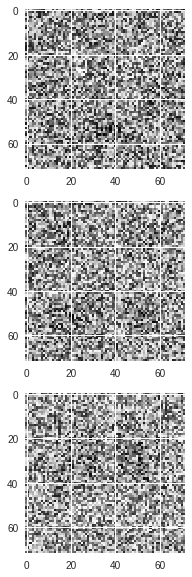

In [18]:
fig = plt.figure(figsize =(20,10))
for k in range(3):
    plt.subplot(3,1,(k+1))
    plt.imshow(SGD_weights_images[:,k].reshape((IMAGE_SIZE, IMAGE_SIZE)))

### ADAM

In [19]:
Adam_weights = model_adam.get_weights()
Adam_weights

[array([[ 0.02855742, -0.02880854, -0.03400203],
        [ 0.02626467, -0.02847804,  0.02550398],
        [-0.01482969,  0.02602756, -0.01697974],
        ...,
        [-0.02097206,  0.01973302,  0.01682057],
        [-0.01247816, -0.01640387, -0.03500554],
        [-0.02708792, -0.02299055, -0.01655111]], dtype=float32),
 array([ 0.00189602, -0.00099734, -0.00110849], dtype=float32)]

In [20]:
Adam_weights_images = Adam_weights[0]
Adam_weights_images.shape

(5184, 3)

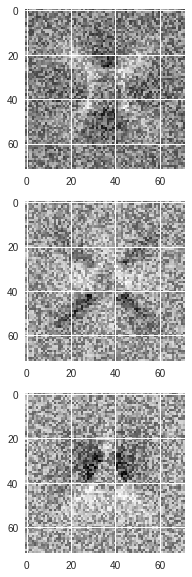

In [21]:
fig = plt.figure(figsize =(20,10))
for k in range(3):
    plt.subplot(3,1,(k+1))
    plt.imshow(Adam_weights_images[:,k].reshape((IMAGE_SIZE, IMAGE_SIZE)))

We can distinguish some forms in the weights of the ADAM optimizer, that can't be seen in the weights of the SGD optimizer

## III)  A more difficult classification problem

### Linear Regressor

In [22]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = to_categorical(Y_train)
model_sgd = Sequential()
model_sgd.add(Dense(3, activation = "softmax", input_shape = (X_train.shape[1],)))
model_sgd.compile(optimizer = optimizer_SGD, loss='mean_squared_error', metrics = ['accuracy'])
model_sgd.fit(X_train, Y_train, batch_size=8, epochs = 200)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/200
300/300 [==============================] - 0s 735us/step - loss: 0.2538 - acc: 0.2467
Epoch 2/200
300/300 [==============================] - 0s 427us/step - loss: 0.2358 - acc: 0.3233
Epoch 3/200
300/300 [==============================] - 0s 426us/step - loss: 0.2317 - acc: 0.3333
Epoch 4/200
300/300 [==============================] - 0s 429us/step - loss: 0.2308 - acc: 0.3300
Epoch 5/200
300/300 [==============================] - 0s 439us/step - loss: 0.2306 - acc: 0.3200
Epoch 6/200
300/300 [==============================] - 0s 490us/step - loss: 0.2295 - acc: 0.3300
Epoch 7/200
300/300 [==============================] - 0s 425us/step - loss: 0.2290 - acc: 0.3400
Epoch 8/200
300/300 [==============================] - 0s 430us/step - loss: 0.2285 - acc: 0.3467
Epoch 9/200
300/300 [==============================] - 0s 430us/step - loss: 0.2281 - acc: 0

In [23]:
print(Y_test[0])
model_SGD.evaluate(X_test, Y_test)

[0. 1. 0.]
300/300 [==============================] - 0s 207us/step


[0.2700147932767868, 0.3633333325386047]

We can see that the accuracy is only of 31%: this classifier isn't adapted to this model

### Convolutionnal Deep Network

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(5, 5), activation = "relu", input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
model_CNN.add(MaxPooling2D())
model_CNN.add(Flatten())
model_CNN.add(Dense(3, activation = "softmax"))

In [0]:
X_train_entry = X_train.reshape(300, IMAGE_SIZE, IMAGE_SIZE, 1)

In [26]:
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_CNN.fit(X_train_entry, Y_train, batch_size=32, epochs = 20)

Epoch 1/20
300/300 [==============================] - 1s 4ms/step - loss: 1.8593 - acc: 0.3233
Epoch 2/20
300/300 [==============================] - 0s 475us/step - loss: 0.9434 - acc: 0.6300
Epoch 3/20
300/300 [==============================] - 0s 453us/step - loss: 0.8035 - acc: 0.7267
Epoch 4/20
300/300 [==============================] - 0s 436us/step - loss: 0.6726 - acc: 0.7767
Epoch 5/20
300/300 [==============================] - 0s 450us/step - loss: 0.5905 - acc: 0.7833
Epoch 6/20
300/300 [==============================] - 0s 476us/step - loss: 0.5744 - acc: 0.7667
Epoch 7/20
300/300 [==============================] - 0s 442us/step - loss: 0.5182 - acc: 0.8200
Epoch 8/20
300/300 [==============================] - 0s 433us/step - loss: 0.4510 - acc: 0.8600
Epoch 9/20
300/300 [==============================] - 0s 436us/step - loss: 0.3979 - acc: 0.8467
Epoch 10/20
300/300 [==============================] - 0s 407us/step - loss: 0.3768 - acc: 0.8833
Epoch 11/20
300/300 [==========

In [27]:
model_CNN.evaluate(X_test.reshape(300, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

300/300 [==============================] - 0s 362us/step


[0.7199889326095581, 0.7]

The accuracy is much better: 68% after only 20 epochs.

## IV) A Regression problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


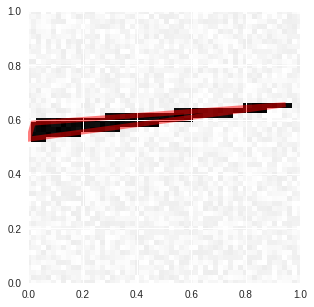

In [28]:
train_set_size = 2000
[X_train_reg, Y_train_reg] = generate_dataset_regression(train_set_size, 20)
visualize_prediction(X_train_reg[1], Y_train_reg[1])

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


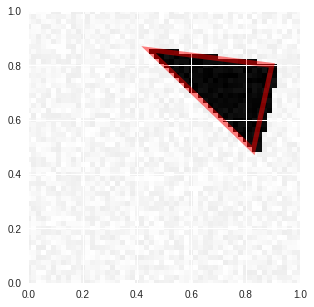

In [29]:
[X_test_reg, Y_test_reg] = generate_test_set_regression()
visualize_prediction(X_test_reg[85], Y_test_reg[85])

In [0]:
#To organize the representation of triangles we will classify the vertices them
#by increasing order of their abscisses

def triangle_normalisation(Y):
    abscisses = [Y[2*k] for k in range(3)]
    ordonnees = [Y[2*k+1] for k in range(3)]
    Y_norm = []
    for i in range(3):
        
        y_index = np.argmin(abscisses)
        Y_norm.append(abscisses[y_index])
        Y_norm.append(ordonnees[y_index])
        del abscisses[y_index]
        del ordonnees[y_index]
    return Y_norm

In [0]:
X_train_reg_entry = X_train_reg.reshape(train_set_size, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_train_reg_norm = np.array([triangle_normalisation(Y_train_reg[k]) for k in range(train_set_size)])

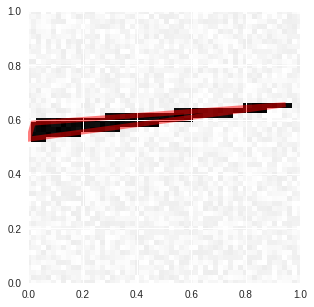

In [32]:
visualize_prediction(X_train_reg[1], Y_train_reg_norm[1])

In [0]:
model = Sequential()
model.add(Conv2D(32, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), kernel_size=(
5,5)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6))

In [34]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train_reg_entry, Y_train_reg_norm, epochs=20, batch_size=32,\
            validation_split=0.3, shuffle=True, verbose=1)

Train on 1400 samples, validate on 600 samples
Epoch 1/20
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0801 - acc: 0.4871 - val_loss: 0.0364 - val_acc: 0.5367
Epoch 2/20
1400/1400 [==============================] - 1s 575us/step - loss: 0.0314 - acc: 0.6021 - val_loss: 0.0267 - val_acc: 0.5833
Epoch 3/20
1400/1400 [==============================] - 1s 560us/step - loss: 0.0236 - acc: 0.6436 - val_loss: 0.0222 - val_acc: 0.6550
Epoch 4/20
1400/1400 [==============================] - 1s 563us/step - loss: 0.0183 - acc: 0.6936 - val_loss: 0.0153 - val_acc: 0.7433
Epoch 5/20
1400/1400 [==============================] - 1s 555us/step - loss: 0.0131 - acc: 0.7493 - val_loss: 0.0122 - val_acc: 0.7617
Epoch 6/20
1400/1400 [==============================] - 1s 568us/step - loss: 0.0100 - acc: 0.7757 - val_loss: 0.0111 - val_acc: 0.7667
Epoch 7/20
1400/1400 [==============================] - 1s 564us/step - loss: 0.0085 - acc: 0.8021 - val_loss: 0.0097 - val_acc: 0.7683
Epo

In [35]:
X_test_reg_entry = X_test_reg.reshape(300, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test_reg_norm = np.array([triangle_normalisation(Y_test_reg[k]) for k in range(300)])
model.evaluate(X_test_reg_entry, Y_test_reg_norm)

300/300 [==============================] - 0s 238us/step


[0.007404080281654994, 0.8199999992052714]

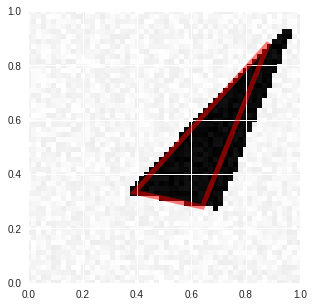

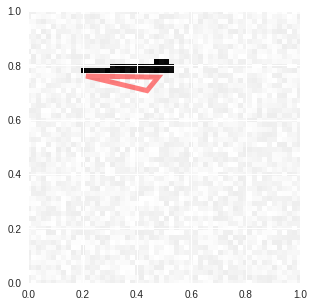

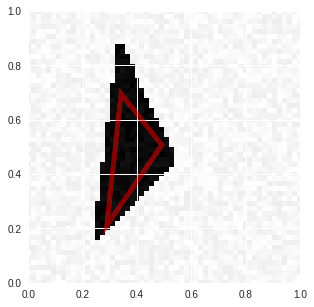

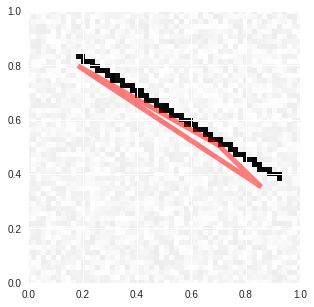

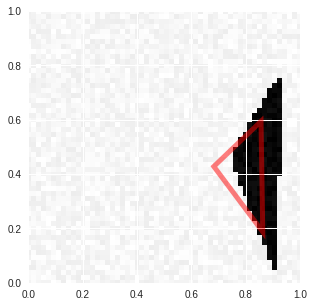

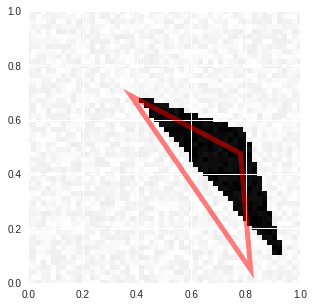

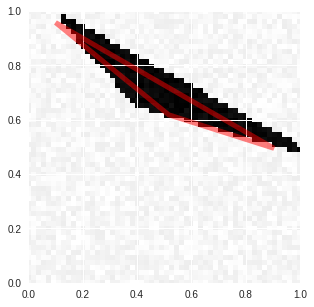

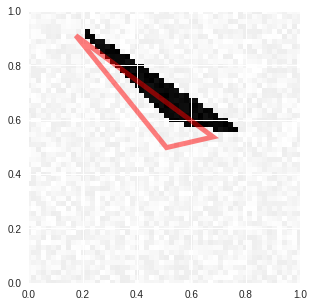

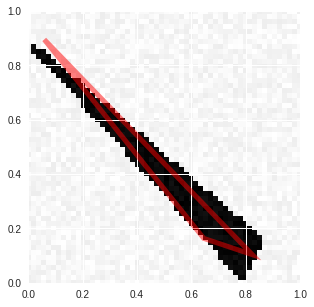

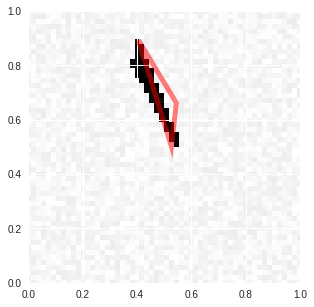

In [36]:
for k in range(10):
    visualize_prediction(X_test_reg_entry[k], model.predict(X_test_reg_entry[k].reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1)))

Even though the accuracy seems to be high, the visualization shows that the prediction isn't as good as what we can see. 

## V) Image Denoising

In [0]:
def generate_a_drawing_noise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

In [0]:
def generate_a_rectangle_noise(free_location=False):
    noise = np.random.randint(0,50)
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_noise(figsize, U, V, noise)

def generate_a_disk_noise(free_location=False):
    noise = np.random.randint(0,50)
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_noise(figsize, U, V, noise)
  
def generate_a_triangle_noise(free_location=False):
    noise = np.random.randint(0,50)
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_noise(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    noise = np.random.randint(0,50)
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_noise(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_noise(free_location)
        else:
            [X[i], V] = generate_a_triangle_noise(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X,Y]
  

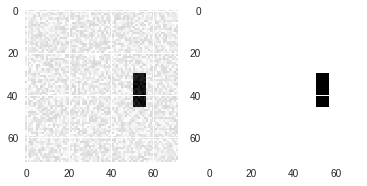

In [67]:
im = generate_a_rectangle_noise(True)
plt.subplot(1,2,1)
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### 1. Training with different kind of figures

In [95]:
train_size = 5000
trainset, cat = generate_dataset_noise(train_size)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [0]:
X_train = trainset[:,0]
Y_train = trainset[:,1]
X_train = X_train.reshape(train_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_train = Y_train.reshape(train_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_train /= 255
Y_train /= 255

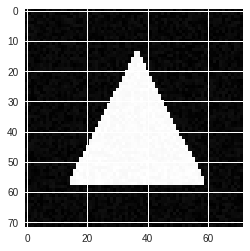

In [97]:
plt.imshow(X_train[430].reshape((IMAGE_SIZE,IMAGE_SIZE)))

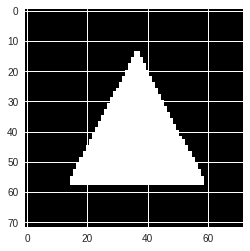

In [98]:
plt.imshow(Y_train[430].reshape((IMAGE_SIZE,IMAGE_SIZE)))

In [0]:
#Hourglass model: 2 layers of downsampling and 2 layers of upsampling
input_ = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))


x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

denoiser = Model(input_, output)
denoiser.compile(optimizer="adam", loss='binary_crossentropy')

In [114]:
denoiser.fit(X_train, Y_train, epochs=250, batch_size=128,\
            validation_split=0.2, shuffle=True, verbose=1)

Train on 4000 samples, validate on 1000 samples
Epoch 1/250
4000/4000 [==============================] - 4s 973us/step - loss: 0.3415 - val_loss: 0.0402
Epoch 2/250
4000/4000 [==============================] - 3s 633us/step - loss: 0.0433 - val_loss: 0.0439
Epoch 3/250
4000/4000 [==============================] - 3s 631us/step - loss: 0.0417 - val_loss: 0.0325
Epoch 4/250
4000/4000 [==============================] - 3s 636us/step - loss: 0.0255 - val_loss: 0.0232
Epoch 5/250
4000/4000 [==============================] - 3s 630us/step - loss: 0.0217 - val_loss: 0.0205
Epoch 6/250
4000/4000 [==============================] - 3s 632us/step - loss: 0.0201 - val_loss: 0.0201
Epoch 7/250
4000/4000 [==============================] - 3s 641us/step - loss: 0.0200 - val_loss: 0.0201
Epoch 8/250
4000/4000 [==============================] - 3s 634us/step - loss: 0.0199 - val_loss: 0.0201
Epoch 9/250
4000/4000 [==============================] - 3s 638us/step - loss: 0.0199 - val_loss: 0.0201
Epoch 1

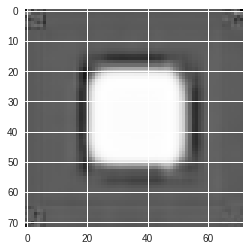

In [115]:
plt.imshow((denoiser.predict(X_train[54].reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))

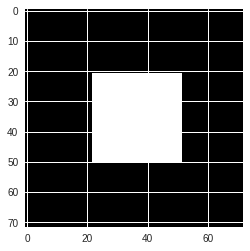

In [116]:
plt.imshow((Y_train[54].reshape((IMAGE_SIZE,IMAGE_SIZE))))

In [117]:
test_size = 20
testset_1, _ = generate_dataset_noise(test_size, 20)

Creating data:
0
10


In [0]:
X_test = testset_1[:,0]
Y_test = testset_1[:,1]
X_test = X_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_test = Y_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_test /= 255
Y_test /= 255

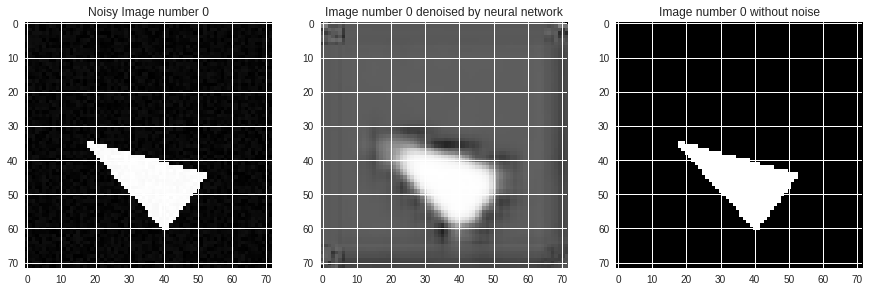

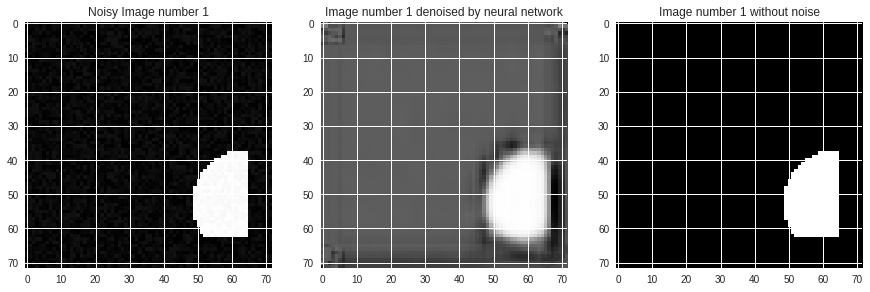

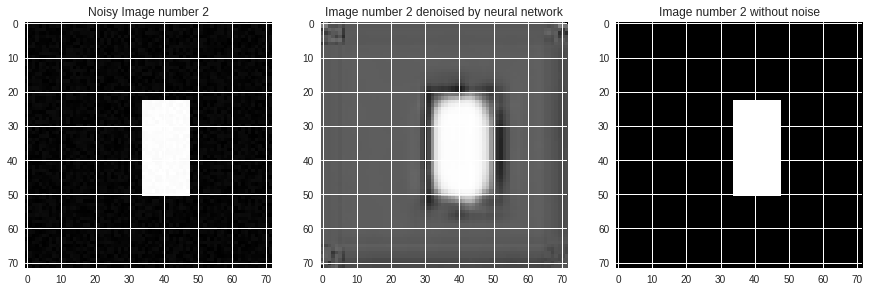

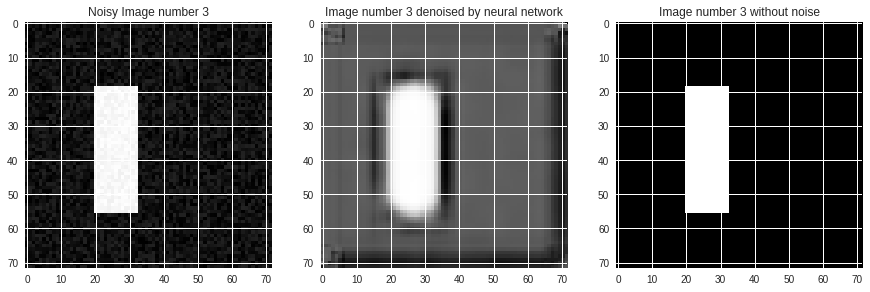

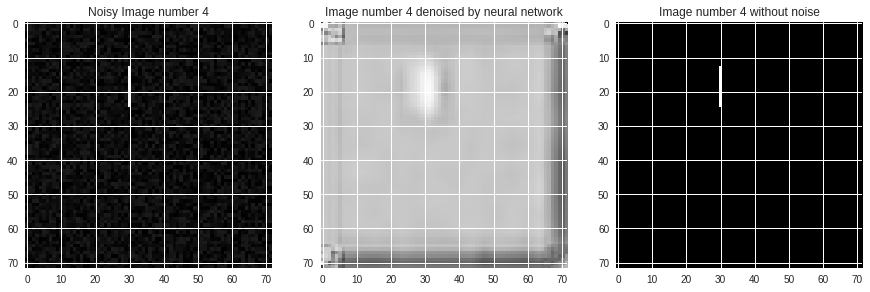

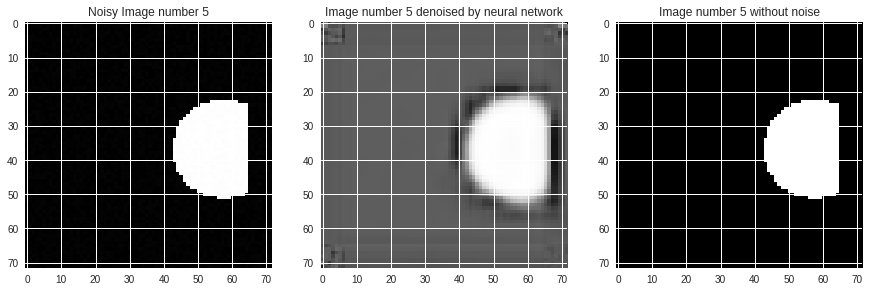

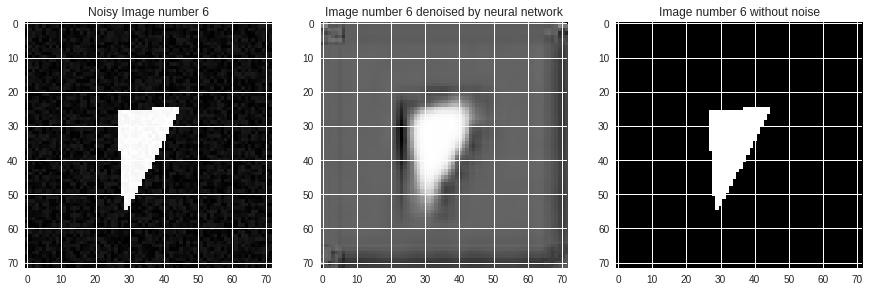

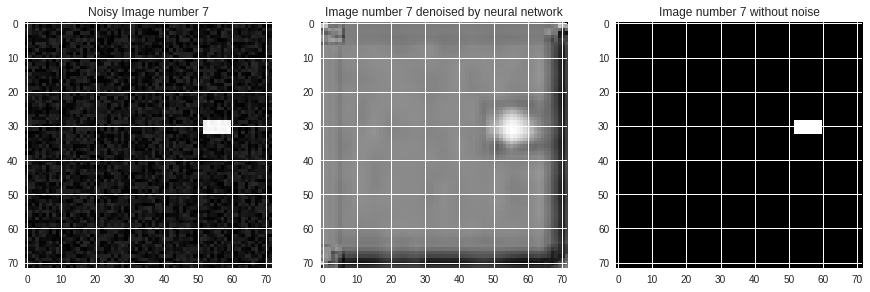

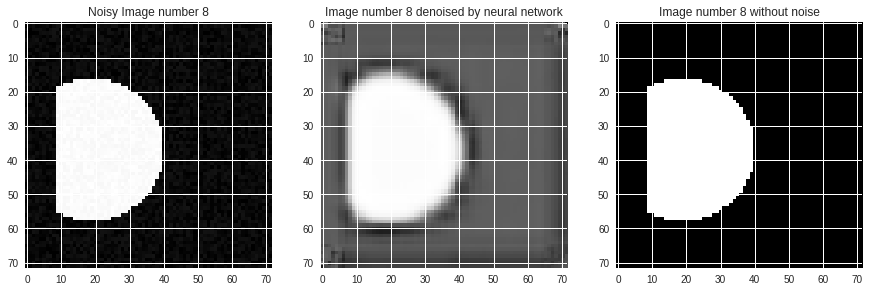

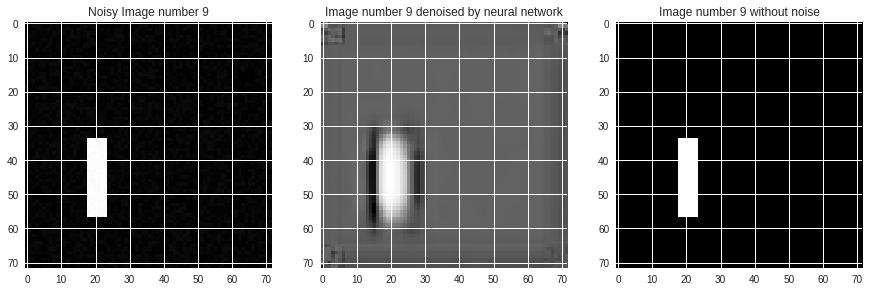

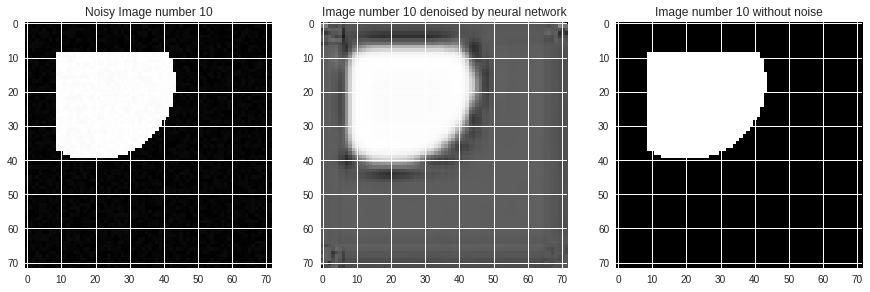

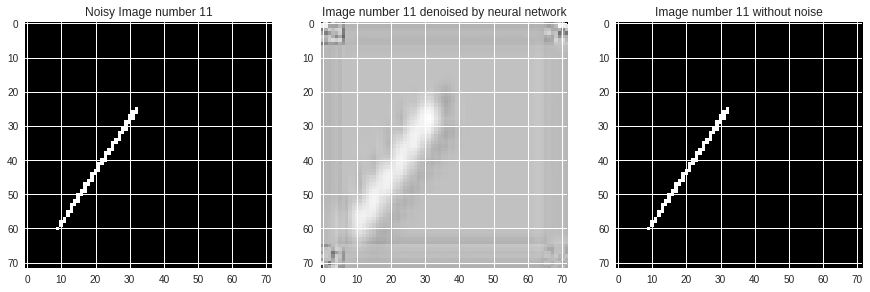

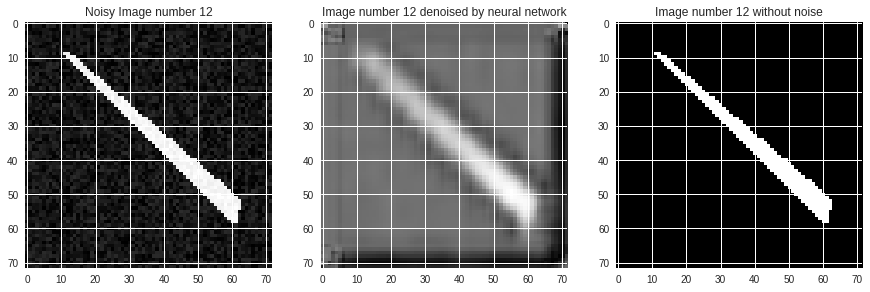

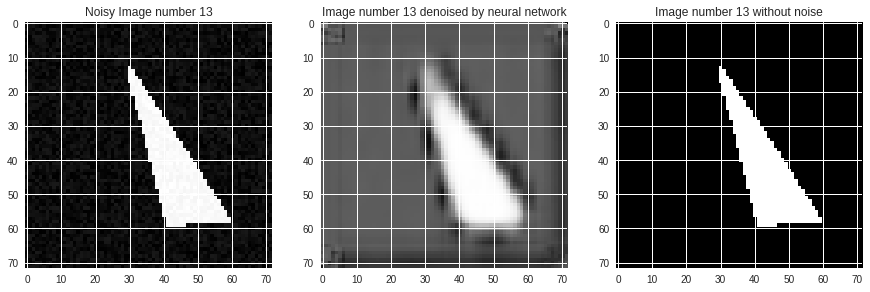

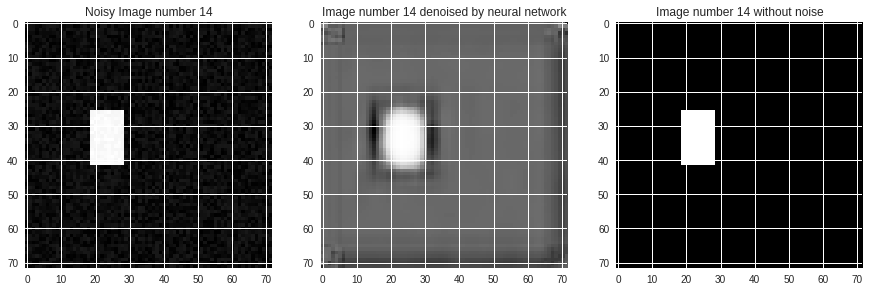

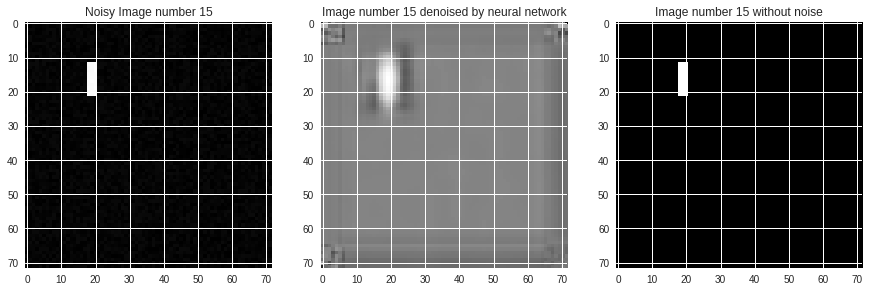

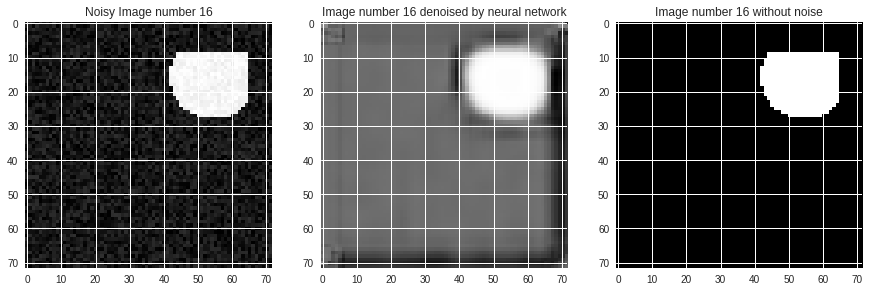

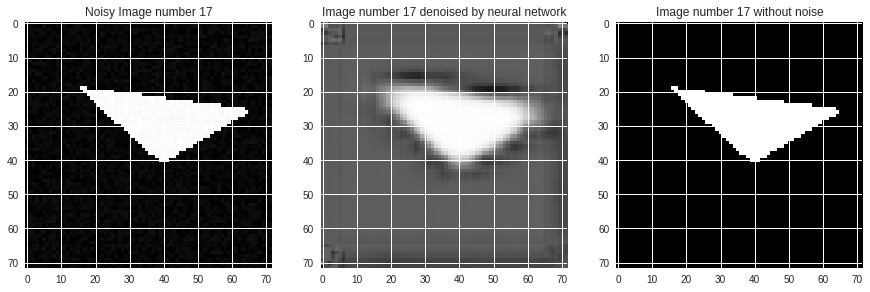

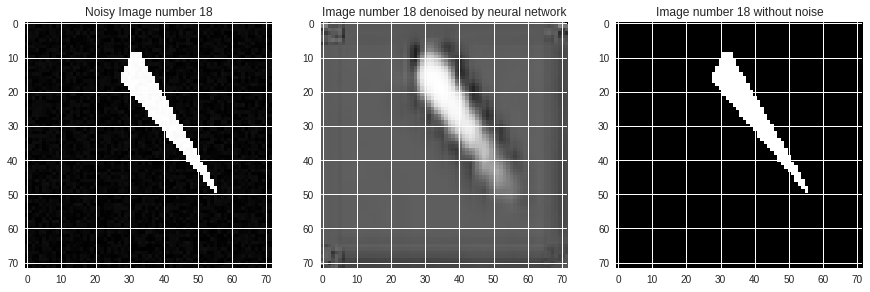

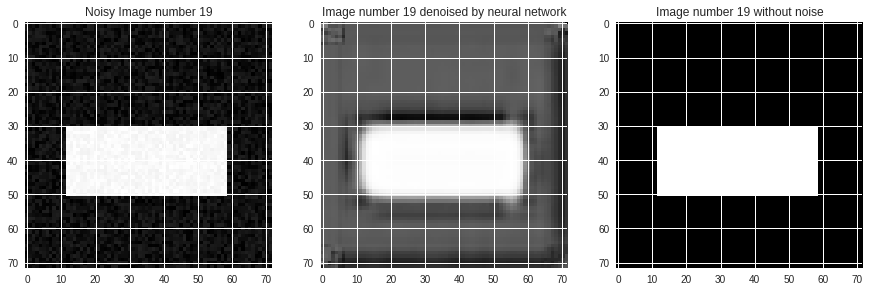

In [119]:
for j in range(test_size):
  fig = plt.figure(figsize = (15,30))
  fig.tight_layout()
  ax = plt.subplot(1, 3, 1)
  plt.imshow(X_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Noisy Image number "+str(j))

  ax = plt.subplot(1, 3, 2)
  plt.imshow((denoiser.predict(X_test[j].reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" denoised by neural network")

  ax = plt.subplot(1, 3, 3)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" without noise")

  

In [122]:
testset_2, _ = generate_dataset_noise(test_size, True)
X_test = testset_2[:,0]
Y_test = testset_2[:,1]
X_test = X_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_test = Y_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_test /= 255
Y_test /= 255

Creating data:
0
10


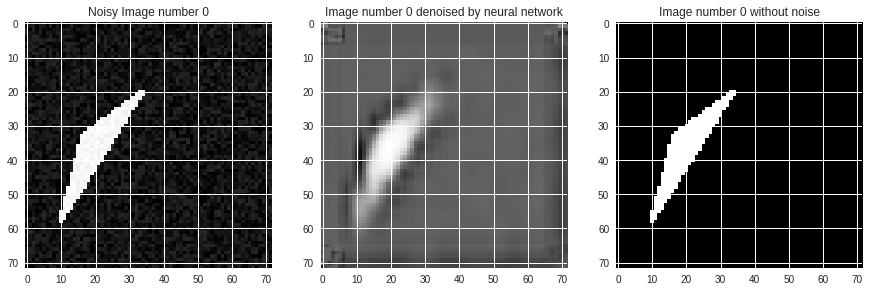

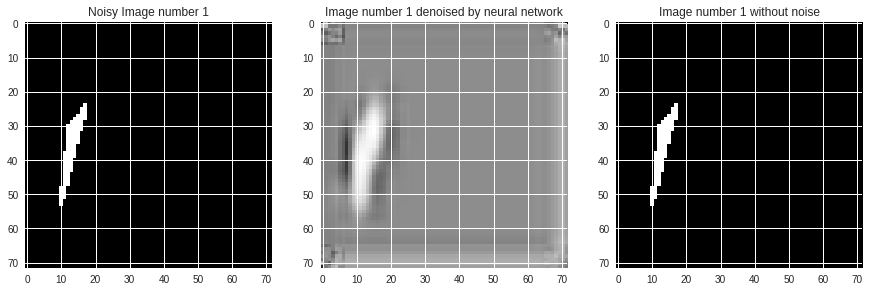

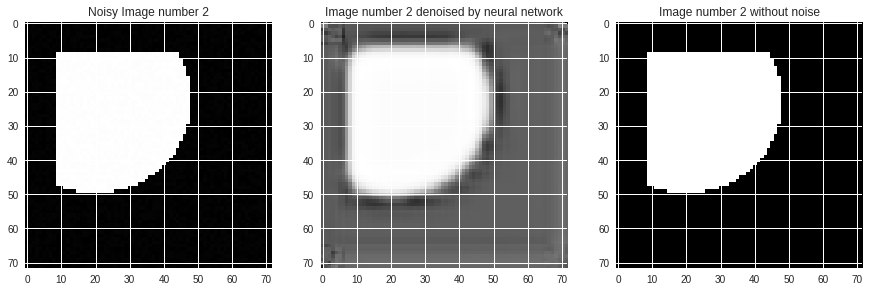

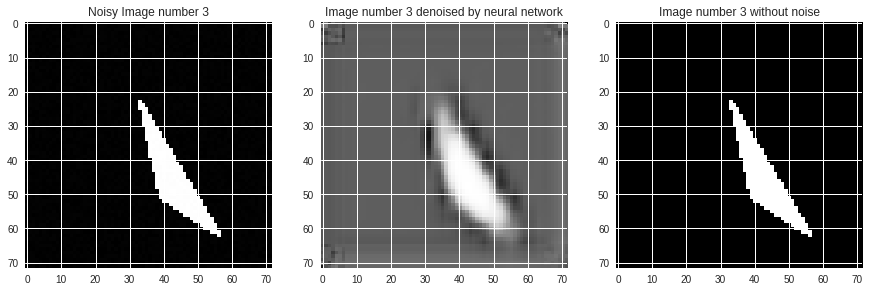

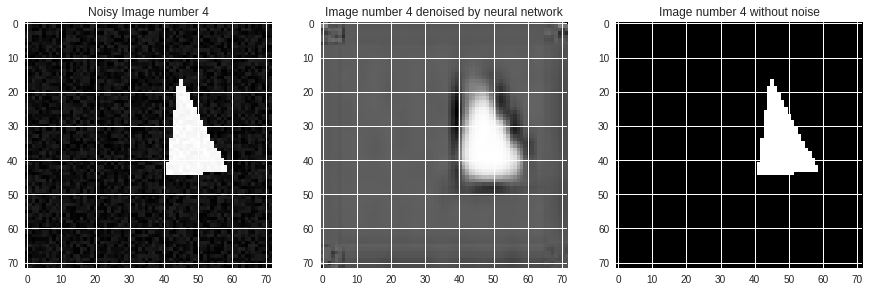

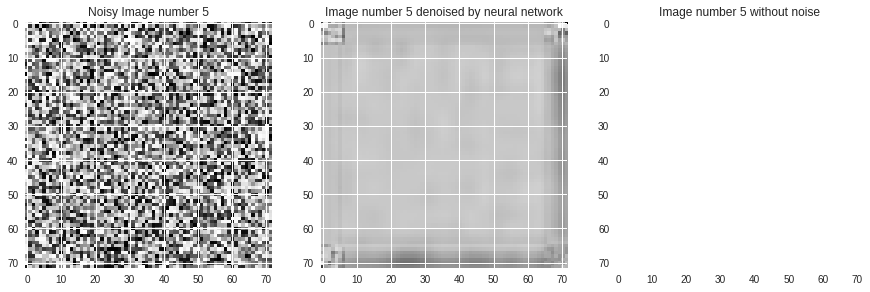

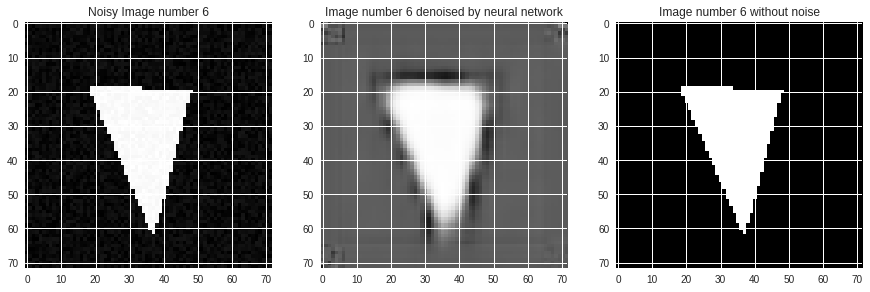

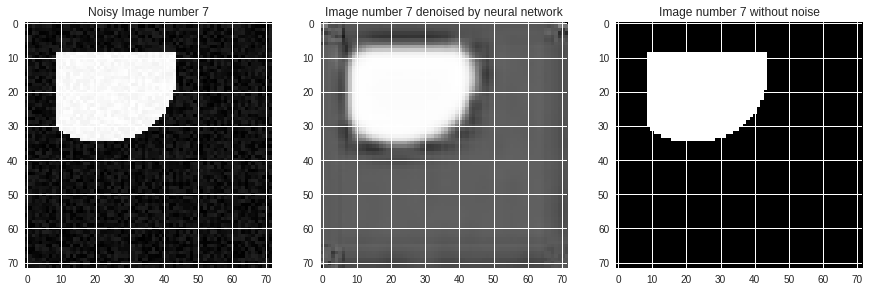

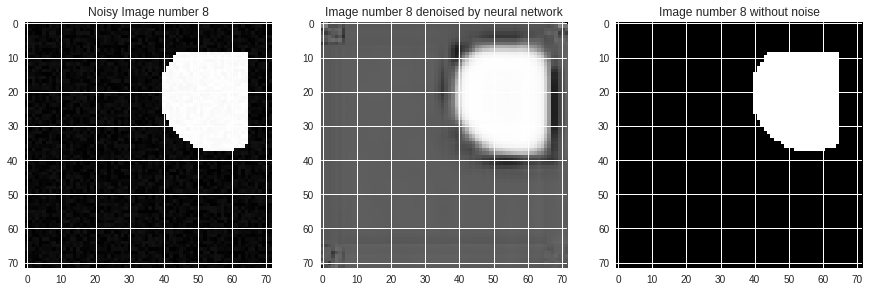

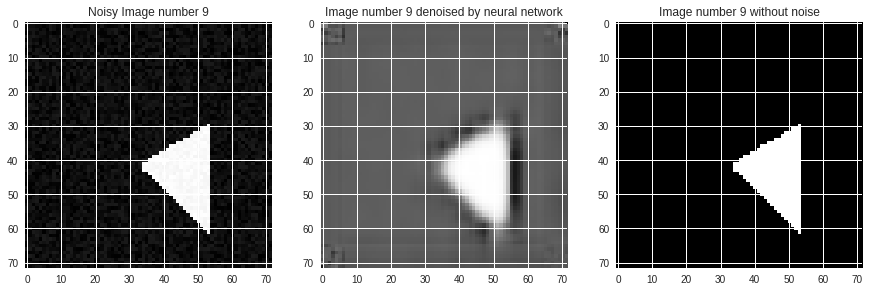

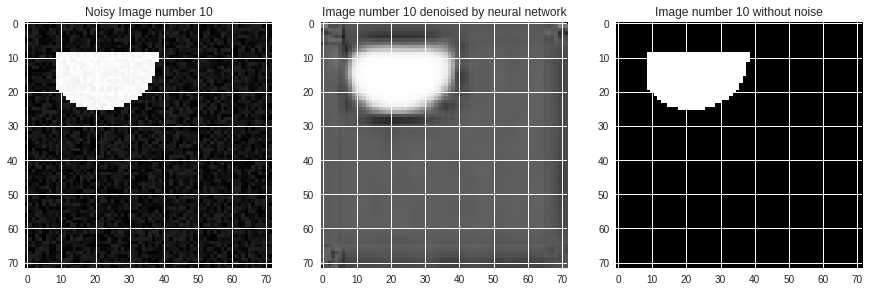

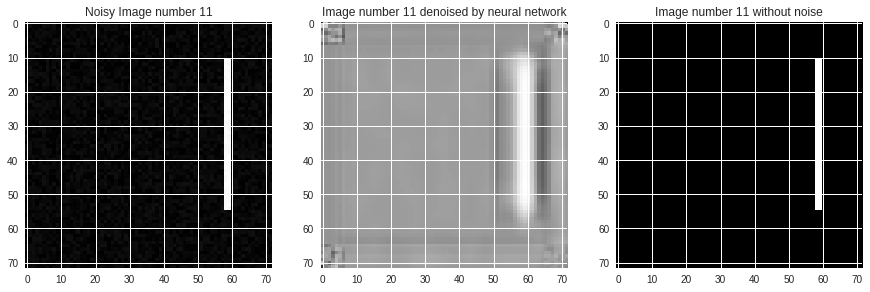

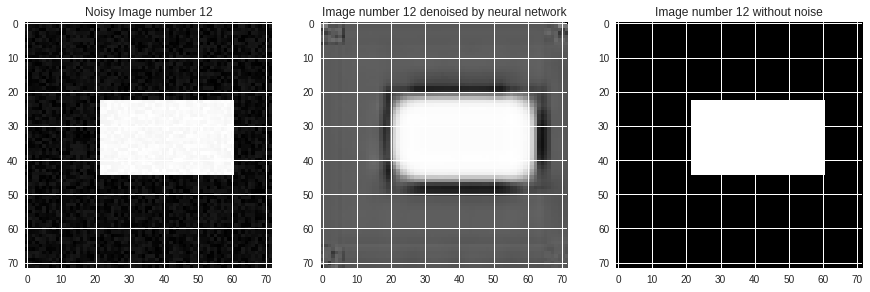

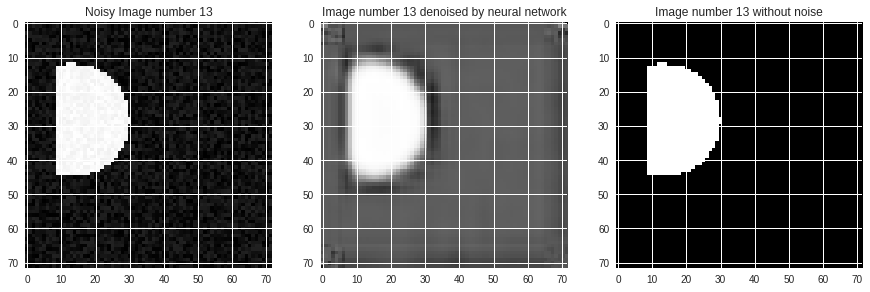

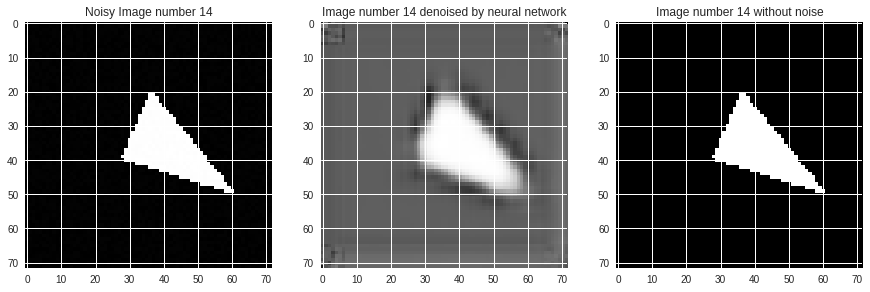

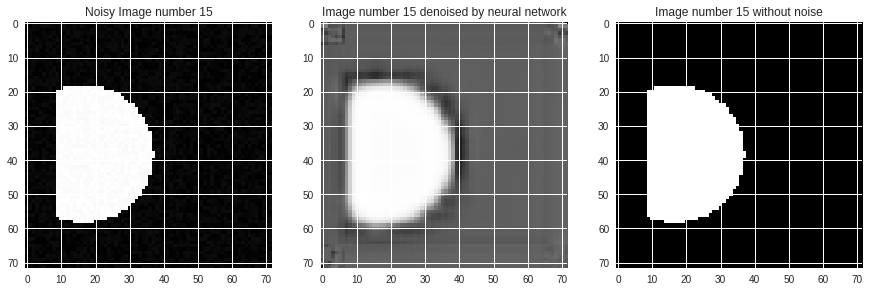

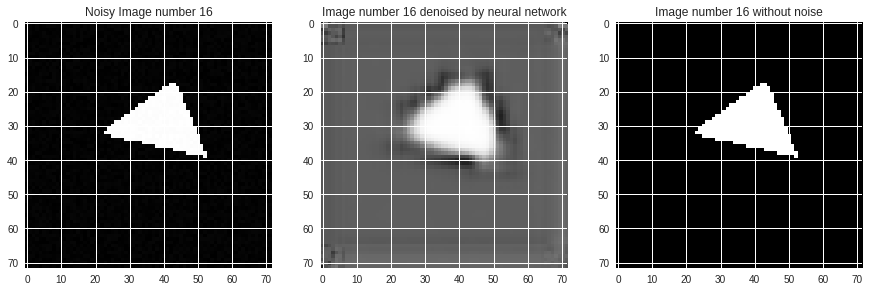

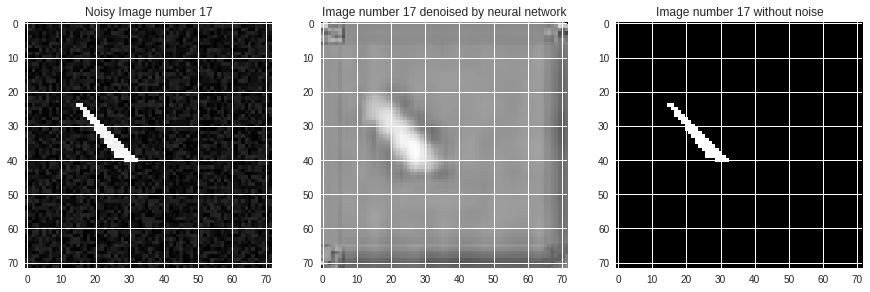

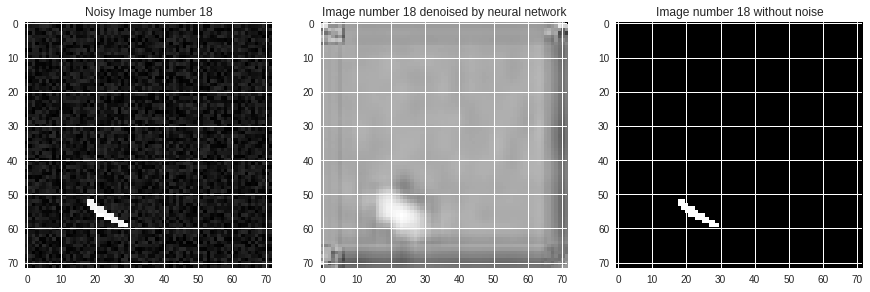

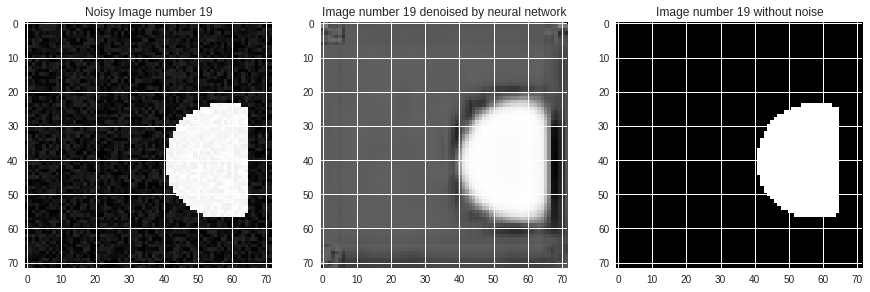

In [123]:
for j in range(test_size):
  fig = plt.figure(figsize = (15,30))
  fig.tight_layout()
  ax = plt.subplot(1, 3, 1)
  plt.imshow(X_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Noisy Image number "+str(j))

  ax = plt.subplot(1, 3, 2)
  plt.imshow((denoiser.predict(X_test[j].reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" denoised by neural network")

  ax = plt.subplot(1, 3, 3)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" without noise")

We can see that the results are not good: the figure is blurred and the background is different in the image without noise and in the image denoised by the neural network. This result is espacially true for the little figures,  which give very bad results

### Test 2 : Training with only one kind of figures (triangles for ex.)

In [0]:
train_size = 2500
trainset = np.array([generate_a_triangle_noise(True)[0] for k in range(train_size)])

In [0]:
input_ = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

denoiser_tri = Model(input_, output)
denoiser_tri.compile(optimizer="adam", loss='binary_crossentropy')

In [0]:
X_train = trainset[:,0]
Y_train = trainset[:,1]
X_train = X_train.reshape(train_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_train = Y_train.reshape(train_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_train /= 255
Y_train /= 255

In [87]:
denoiser_tri.fit(X_train, Y_train, epochs=100, batch_size=128,\
            validation_split=0.2, shuffle=True, verbose=1)

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3230 - val_loss: 0.1574
Epoch 2/100
2000/2000 [==============================] - 1s 635us/step - loss: 0.1138 - val_loss: 0.0418
Epoch 3/100
2000/2000 [==============================] - 1s 629us/step - loss: 0.0309 - val_loss: 0.0271
Epoch 4/100
2000/2000 [==============================] - 1s 634us/step - loss: 0.0245 - val_loss: 0.0218
Epoch 5/100
2000/2000 [==============================] - 1s 637us/step - loss: 0.0204 - val_loss: 0.0188
Epoch 6/100
2000/2000 [==============================] - 1s 633us/step - loss: 0.0181 - val_loss: 0.0165
Epoch 7/100
2000/2000 [==============================] - 1s 628us/step - loss: 0.0159 - val_loss: 0.0149
Epoch 8/100
2000/2000 [==============================] - 1s 634us/step - loss: 0.0141 - val_loss: 0.0133
Epoch 9/100
2000/2000 [==============================] - 1s 632us/step - loss: 0.0128 - val_loss: 0.0121
Epoch 10/1

In [0]:
#Test on a triangle set

testset_tri = np.array([generate_a_triangle_noise(True)[0] for k in range(test_size)])
X_test = testset_tri[:,0]
Y_test = testset_tri[:,1]
X_test = X_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_test = Y_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_test /= 255
Y_test /= 255

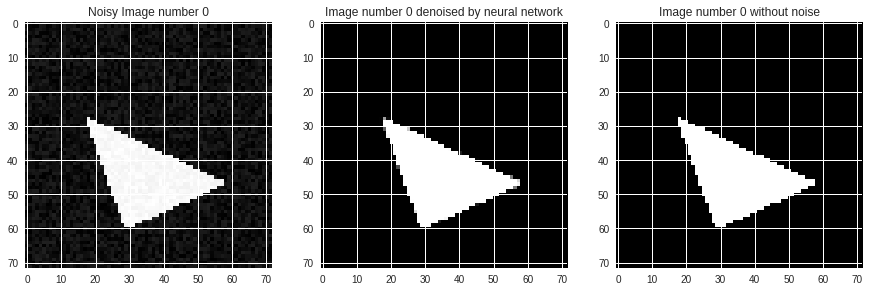

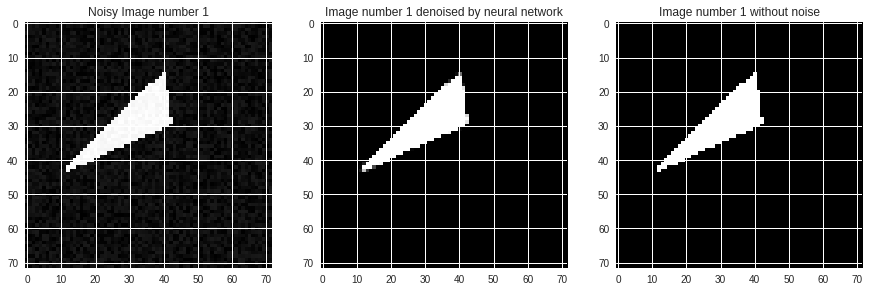

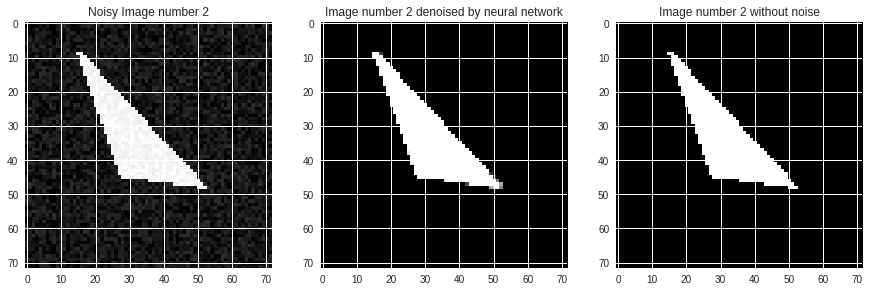

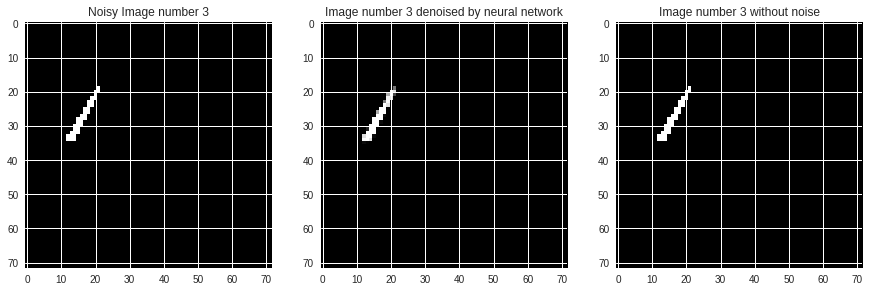

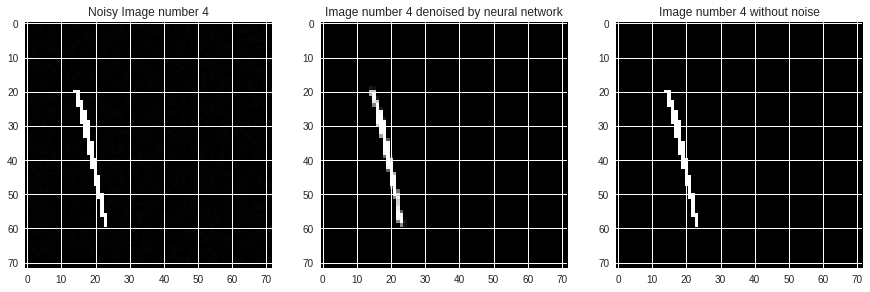

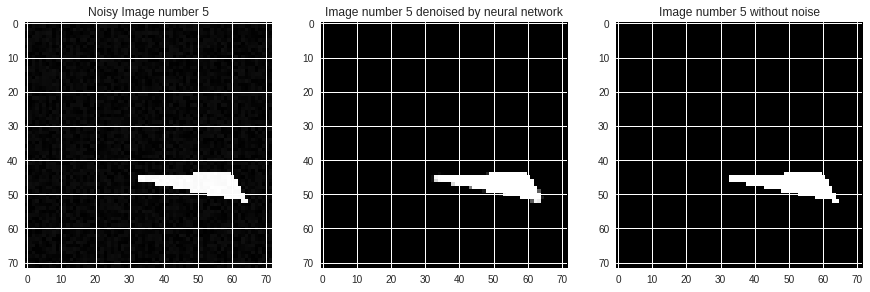

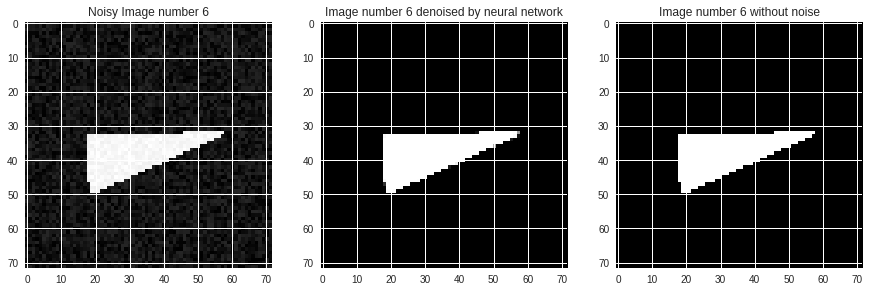

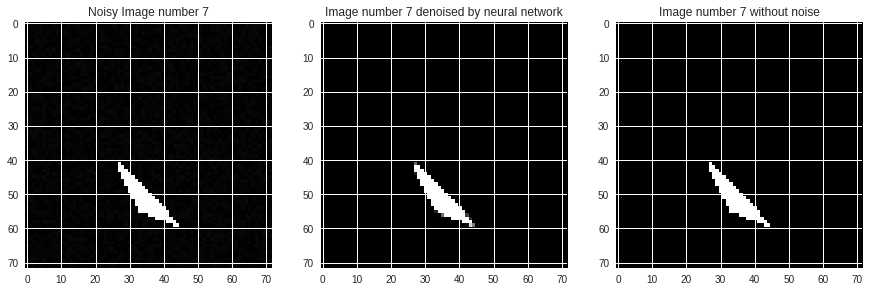

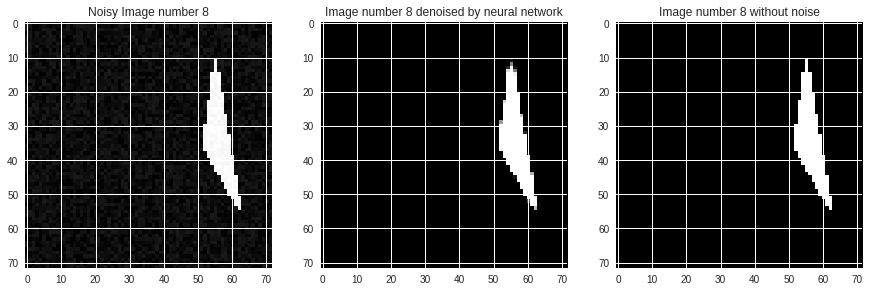

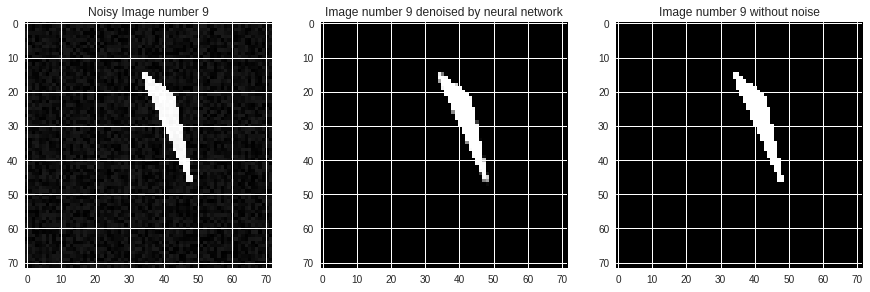

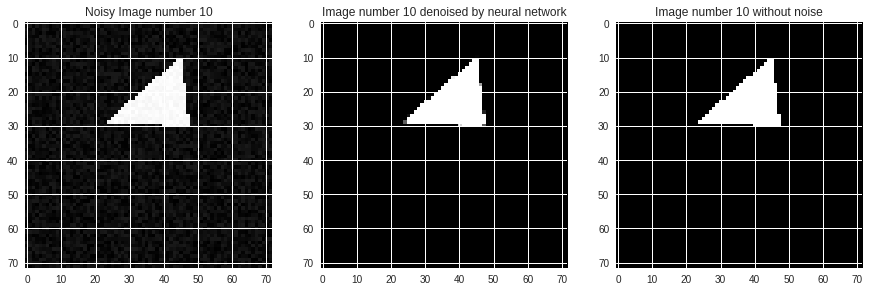

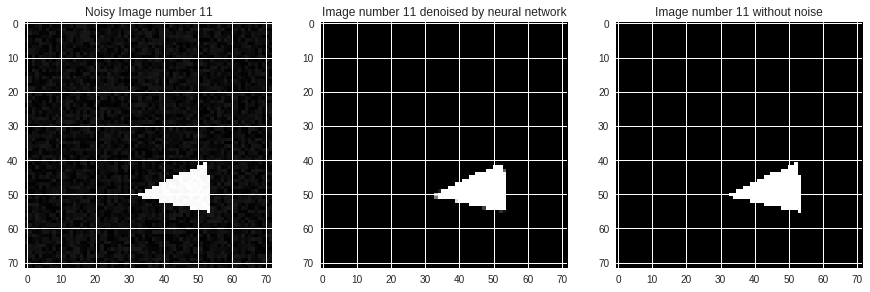

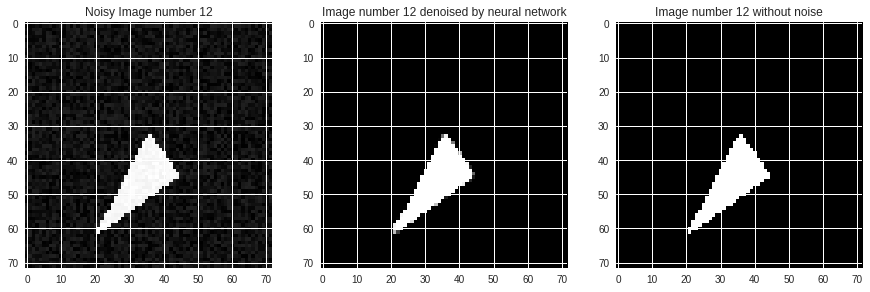

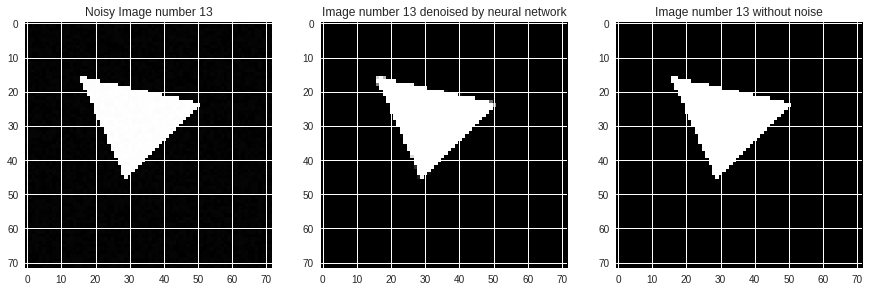

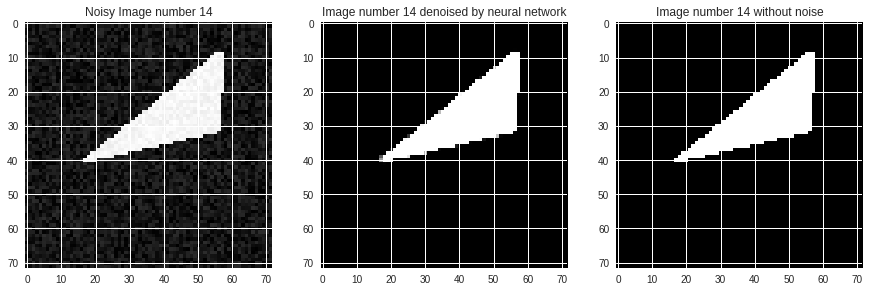

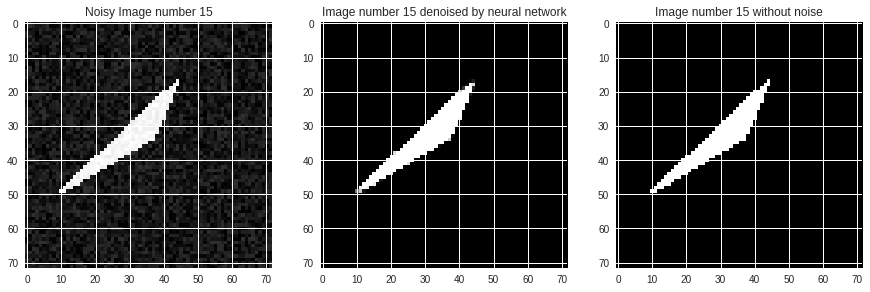

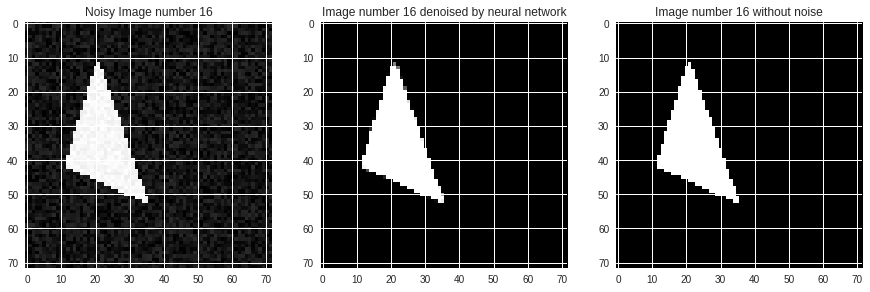

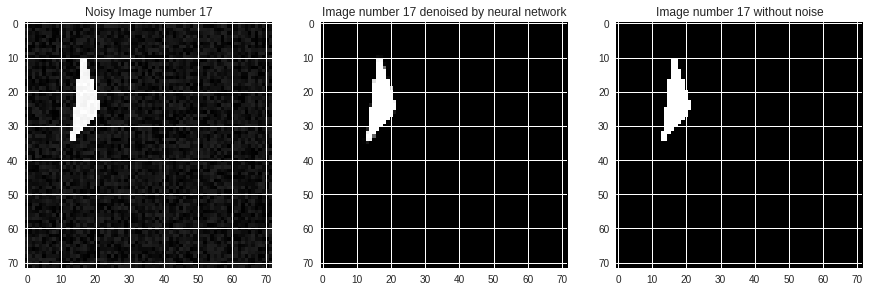

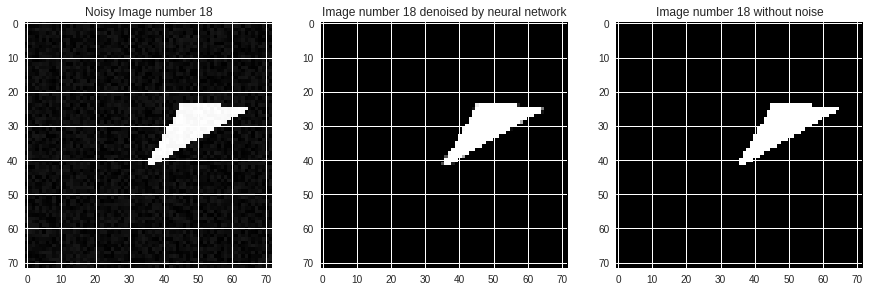

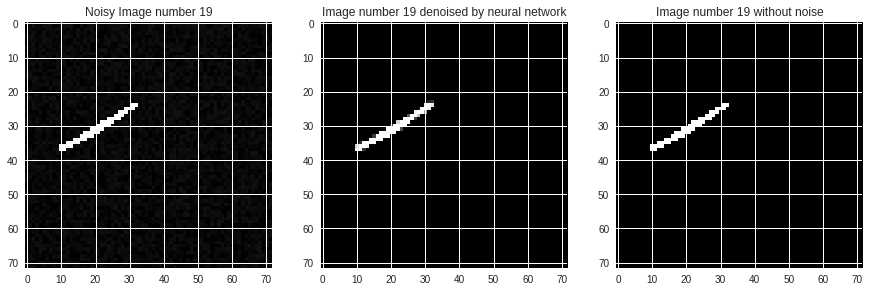

In [90]:
for j in range(test_size):
  fig = plt.figure(figsize = (15,30))
  fig.tight_layout()
  ax = plt.subplot(1, 3, 1)
  plt.imshow(X_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Noisy Image number "+str(j))

  ax = plt.subplot(1, 3, 2)
  plt.imshow((denoiser_tri.predict(X_test[j].reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" denoised by neural network")

  ax = plt.subplot(1, 3, 3)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" without noise")

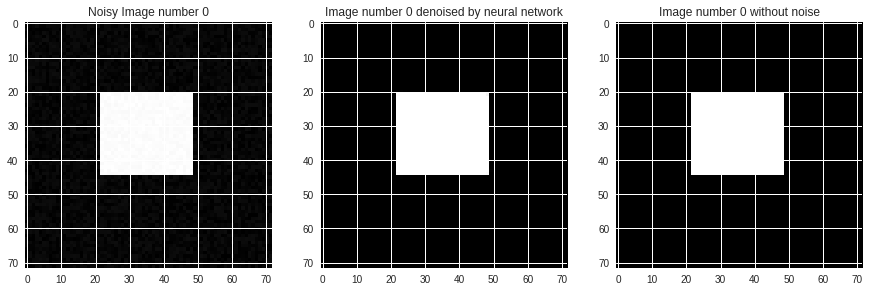

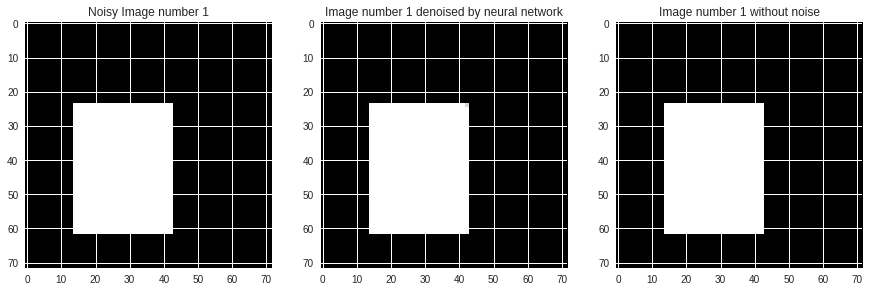

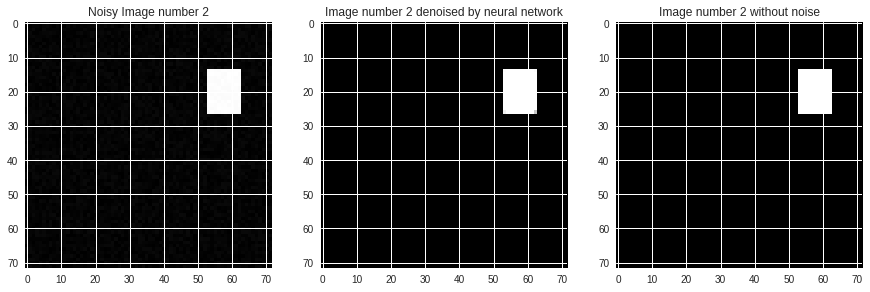

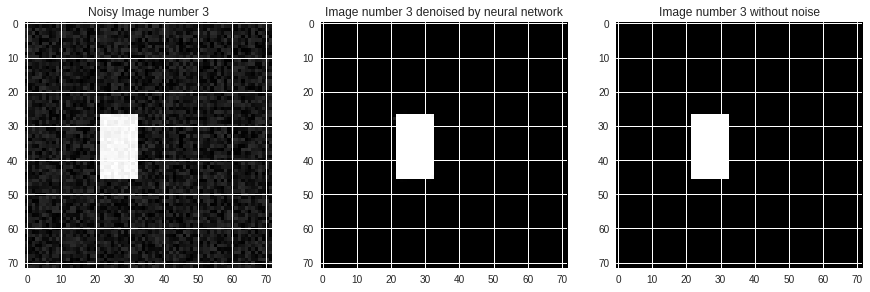

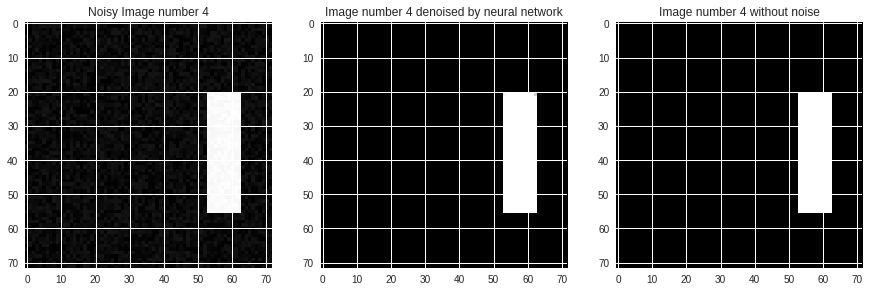

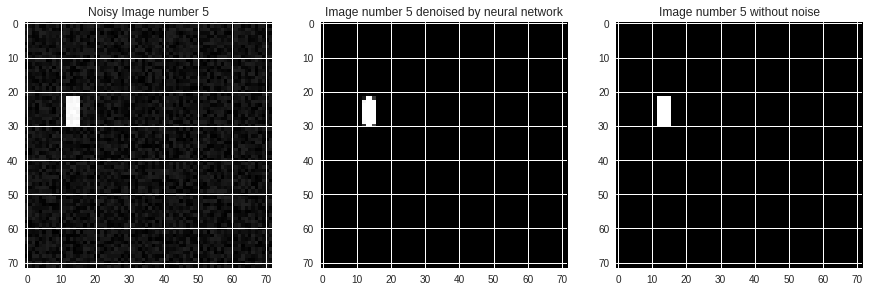

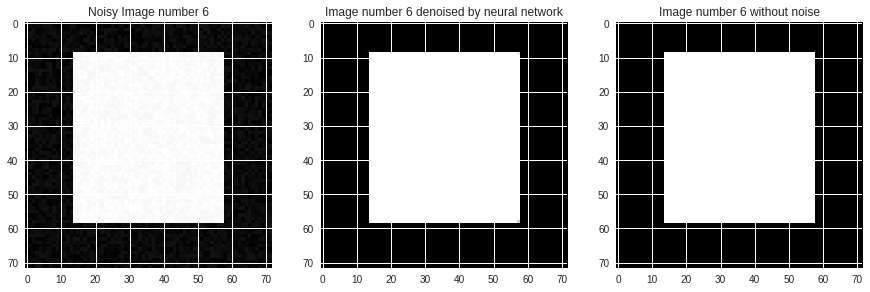

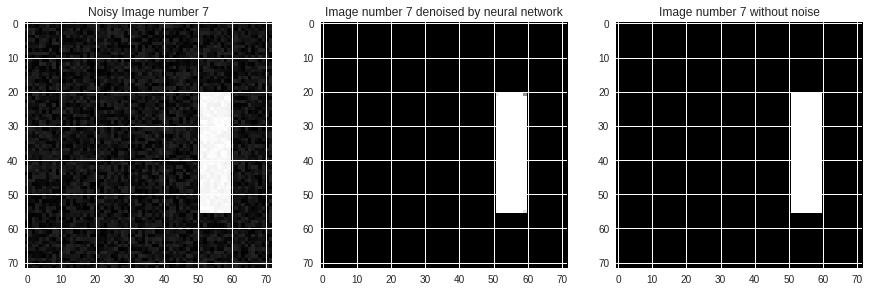

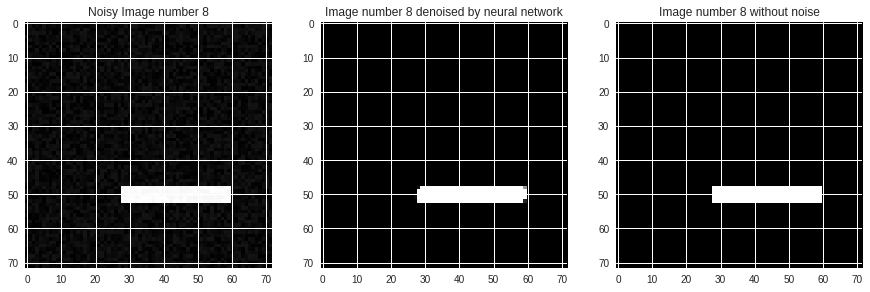

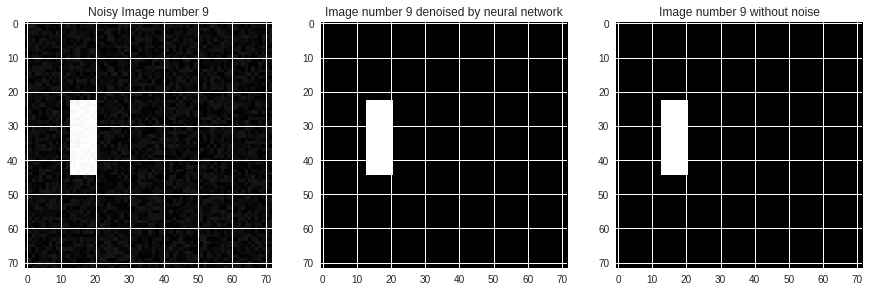

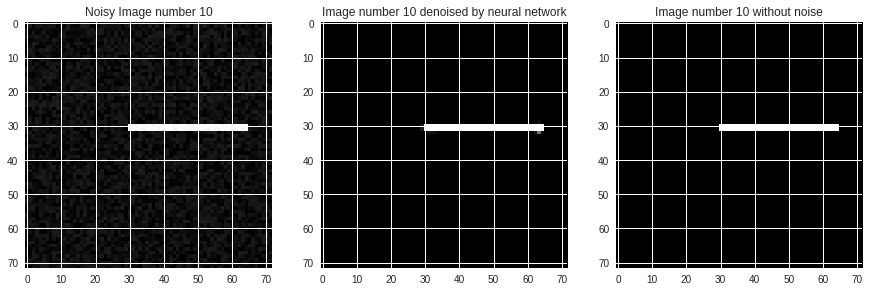

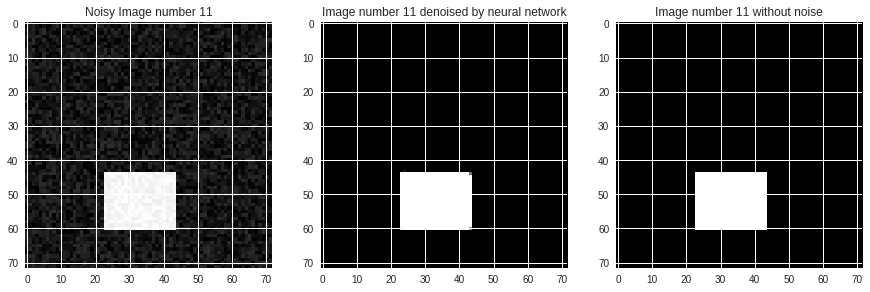

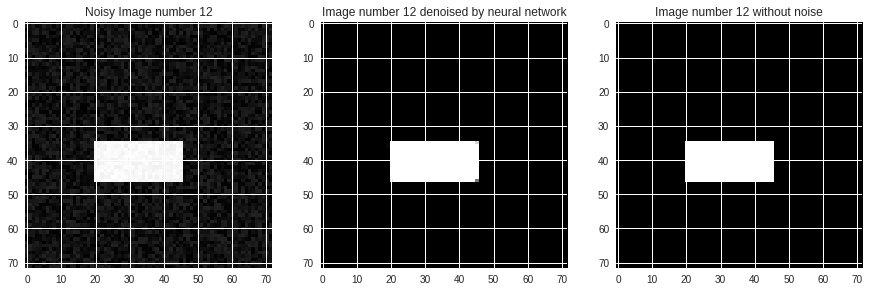

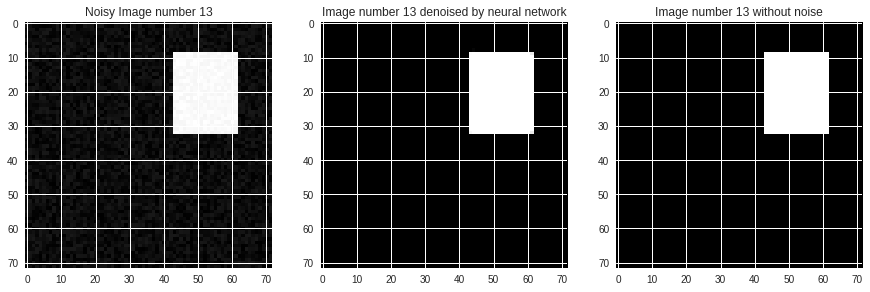

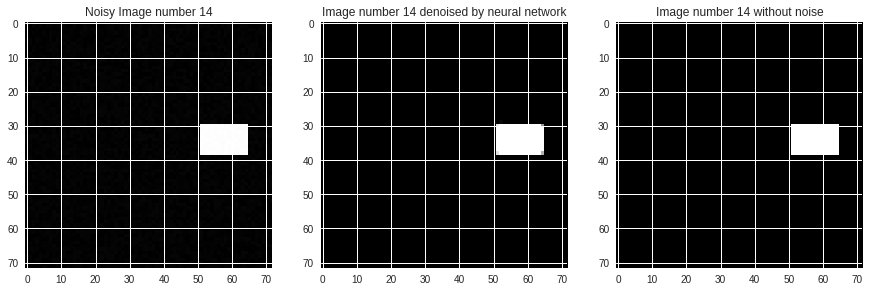

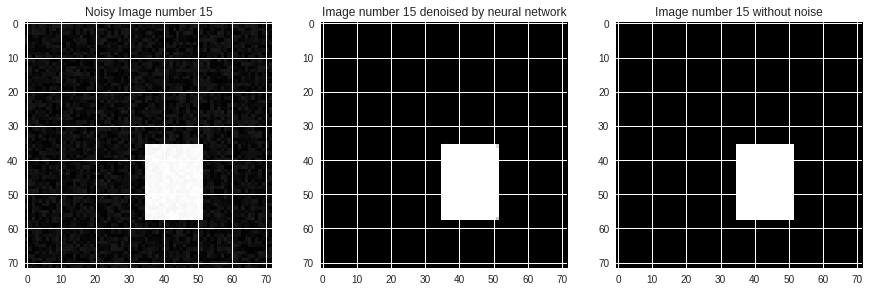

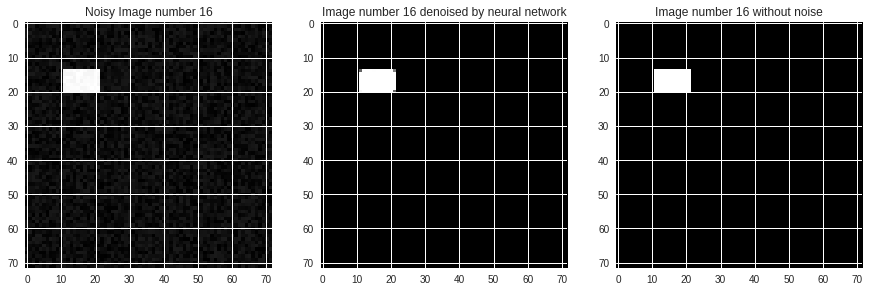

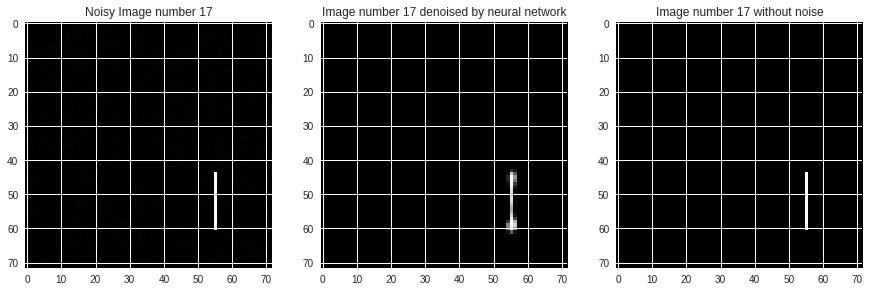

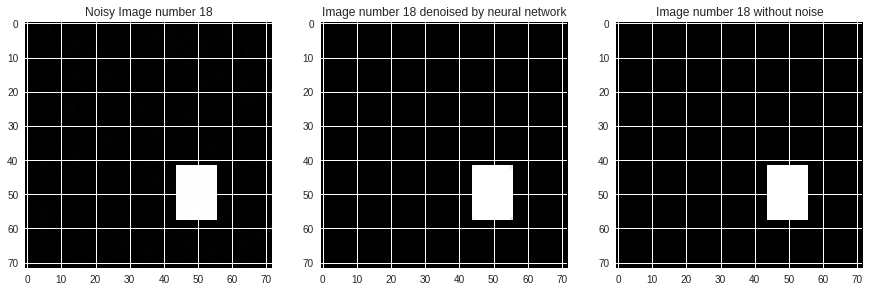

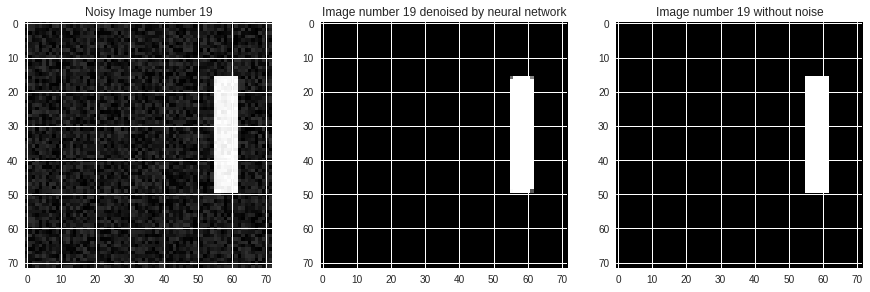

In [92]:
#Test on a rectangle set

testset_rec = np.array([generate_a_rectangle_noise(True) for k in range(20)])
X_test = testset_rec[:,0]
Y_test = testset_rec[:,1]
X_test = X_test.reshape(20, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test = Y_test.reshape(20, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test /= 255
Y_test /= 255

for j in range(20):
  fig = plt.figure(figsize = (15,30))
  fig.tight_layout()
  ax = plt.subplot(1, 3, 1)
  im = X_test[j]
  plt.imshow(im.reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Noisy Image number "+str(j))

  ax = plt.subplot(1, 3, 2)
  plt.imshow((denoiser_tri.predict(im.reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" denoised by neural network")

  ax = plt.subplot(1, 3, 3)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" without noise")

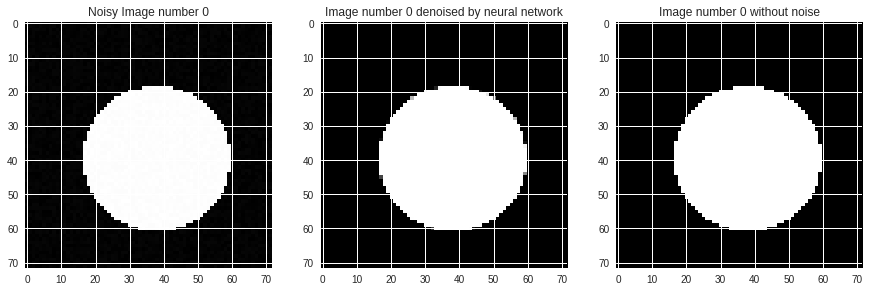

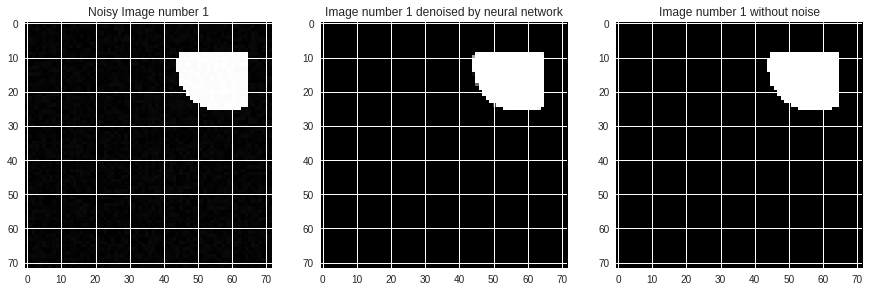

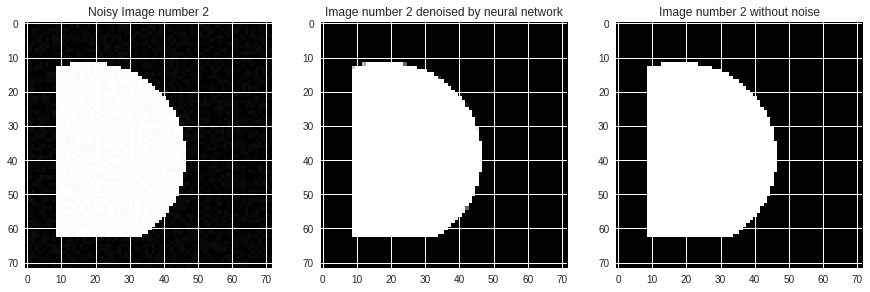

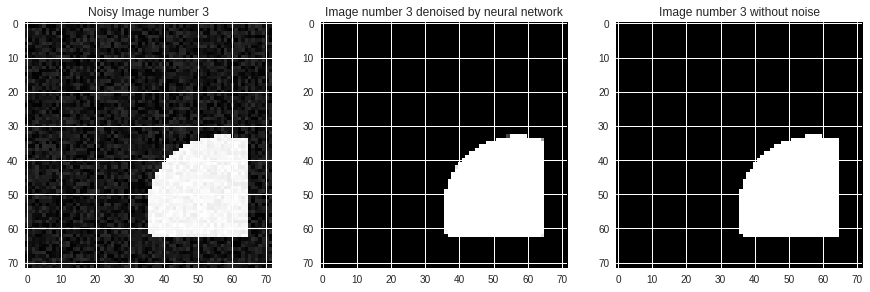

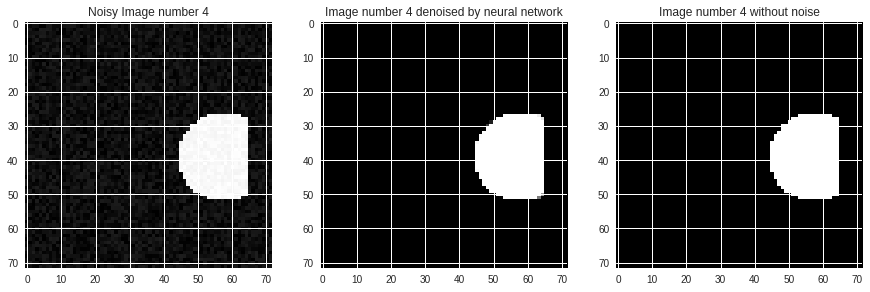

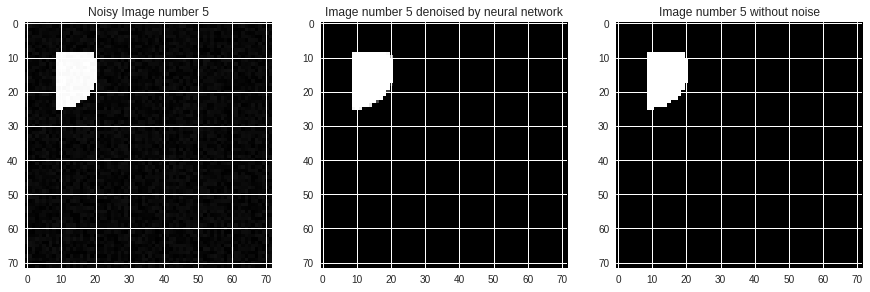

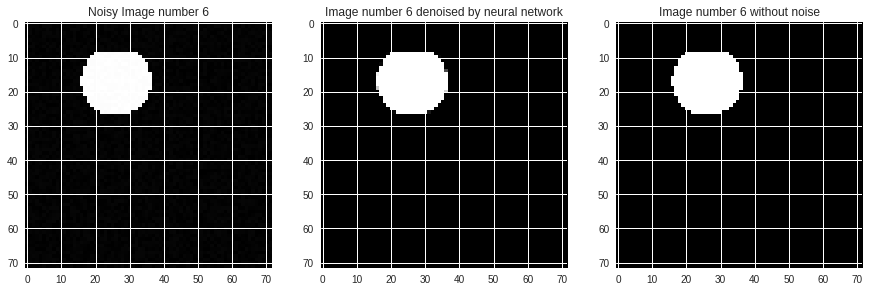

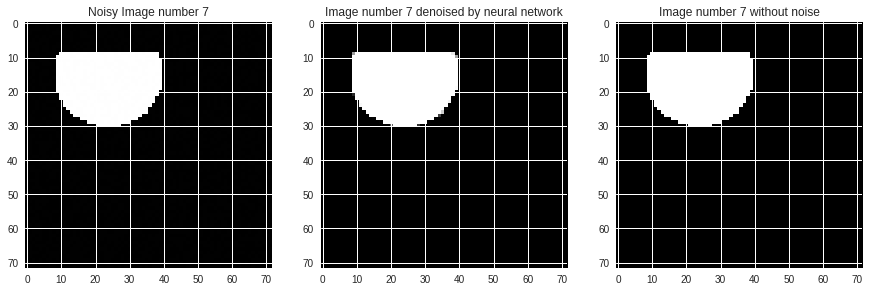

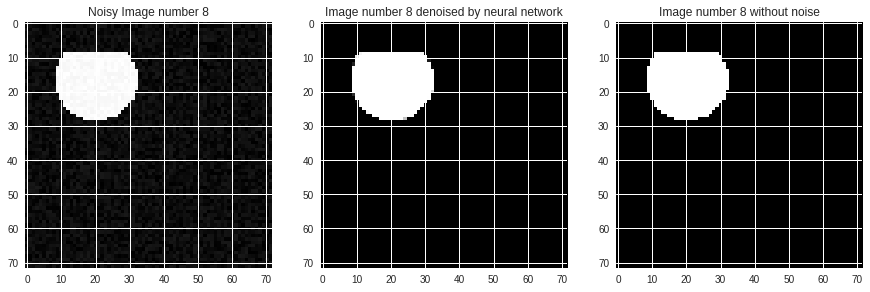

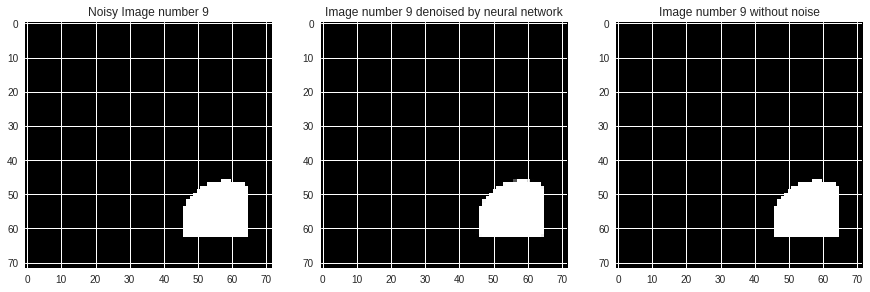

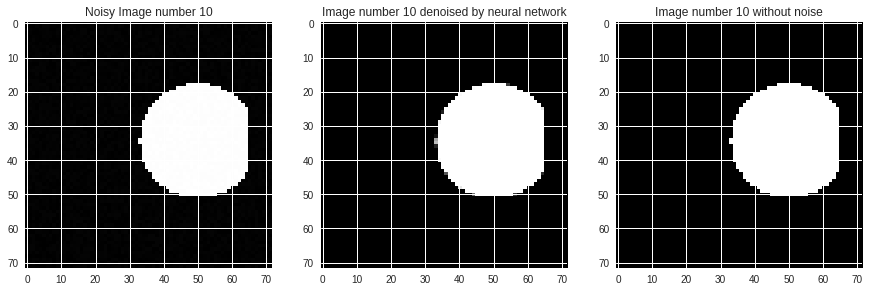

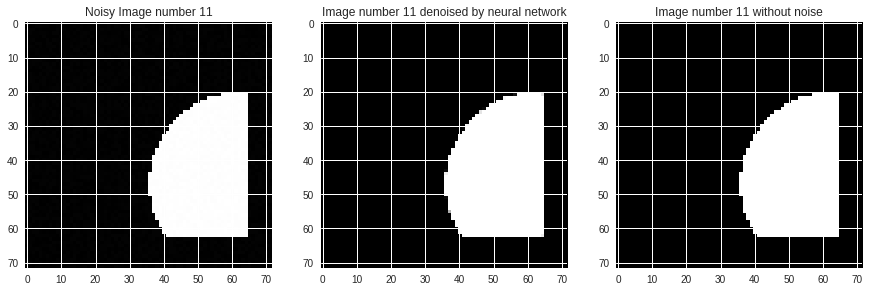

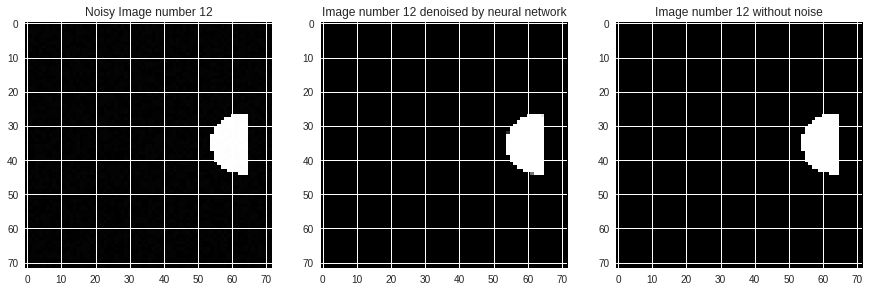

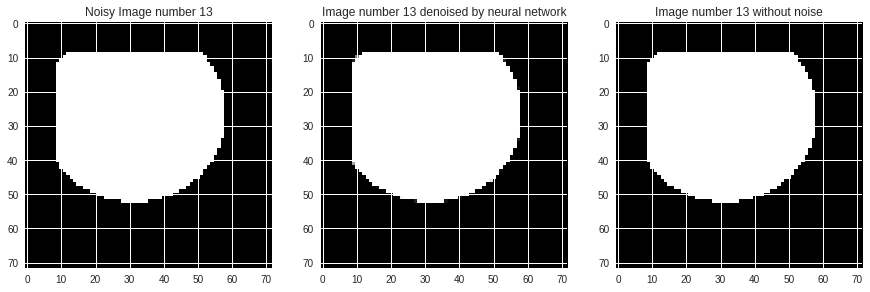

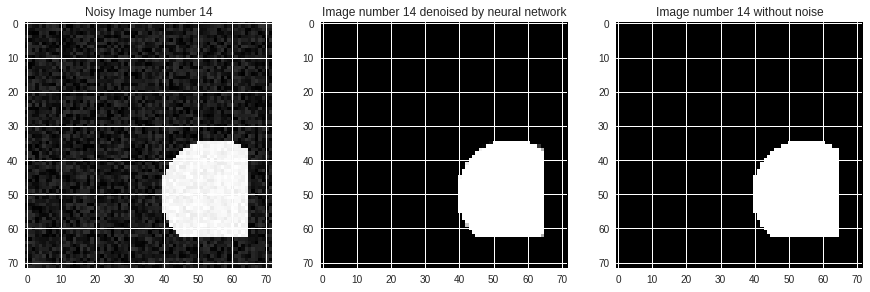

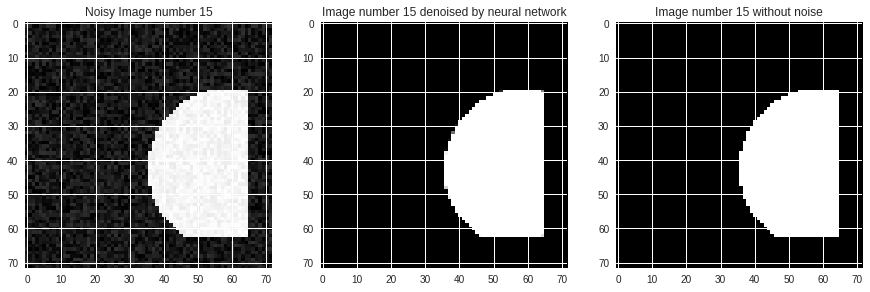

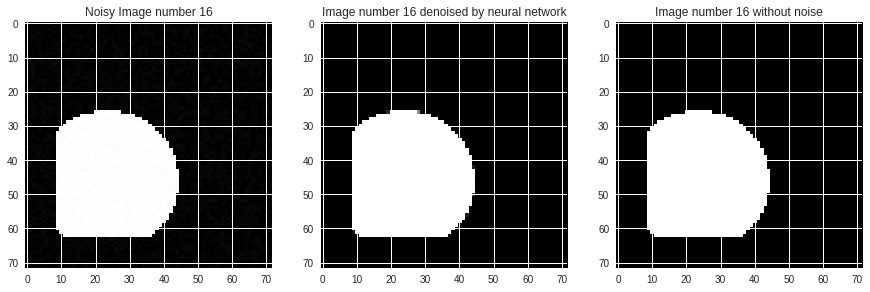

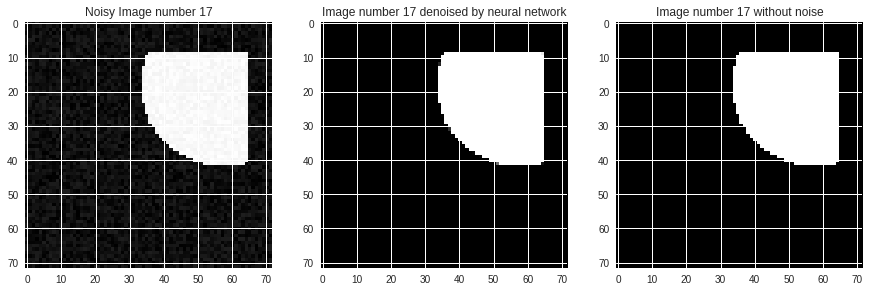

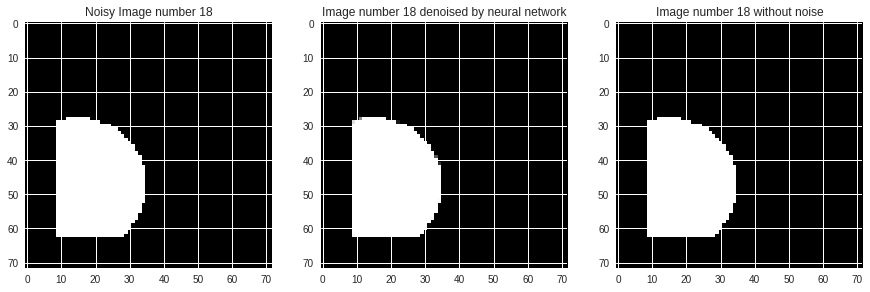

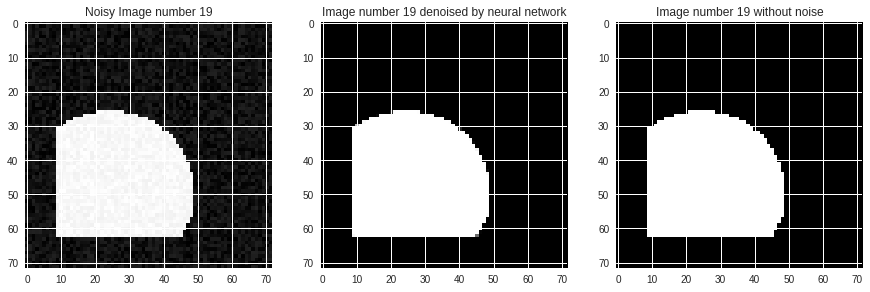

In [94]:
#Test on a disk set

testset_disk = np.array([generate_a_disk_noise(True) for k in range(20)])
X_test = testset_disk[:,0]
Y_test = testset_disk[:,1]
X_test = X_test.reshape(20, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test = Y_test.reshape(20, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test /= 255
Y_test /= 255

for j in range(20):
  fig = plt.figure(figsize = (15,30))
  fig.tight_layout()
  ax = plt.subplot(1, 3, 1)
  im = X_test[j]
  plt.imshow(im.reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Noisy Image number "+str(j))

  ax = plt.subplot(1, 3, 2)
  plt.imshow((denoiser_tri.predict(im.reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" denoised by neural network")

  ax = plt.subplot(1, 3, 3)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
  plt.title("Image number "+str(j) +" without noise")


We can see that this model has a better performance than the previous one, wih a background perfectly denoised and with only some pixels wrongfully colored at the boundaries  of the figure, and works on all kind of figures even though there is only one figure used for the training. It may be because there is no big difference on the denoising for one kind of figure and for another one
